### Cell 1 - creating groups ###

--- Clan Grouping and Complex Internal Sorting Results ---

=== Generation 1 (2 Groups) ===
Group 1 (2 people):
  - ID 58: Фёкла
  - ID 51: Каземир
--------------------
Group 2 (2 people):
  - ID 60: Уститья
  - ID 59: Тарас
--------------------

=== Generation 2 (1 Groups) ===
Group 1 (3 people):
  - ID 32: Василий
  - ID 31: Софья
  - ID 52: Фёдор
--------------------

=== Generation 3 (2 Groups) ===
Group 1 (2 people):
  - ID 28: Вера
  - ID 27: Аппалинарий
--------------------
Group 2 (8 people):
  - ID 30: Александр
  - ID 29: Лилина
  - ID 33: Фёдор
  - ID 36: Евгения
  - ID 34: Ольга
  - ID 38: Иван
  - ID 35: Николай
  - ID 44: Нина
--------------------

=== Generation 4 (5 Groups) ===
Group 1 (8 people):
  - ID 2: Марина
  - ID 1: Михаил
  - ID 21: Леонид
  - ID 22: Елена
  - ID 14: Ольга
  - ID 15: Дмитрий
  - ID 18: Сергей
  - ID 19: Виктория
--------------------
Group 2 (2 people):
  - ID 11: Милана
  - ID 10: Николай
--------------------
Group 3 (2 people):
  - ID 53: Ната

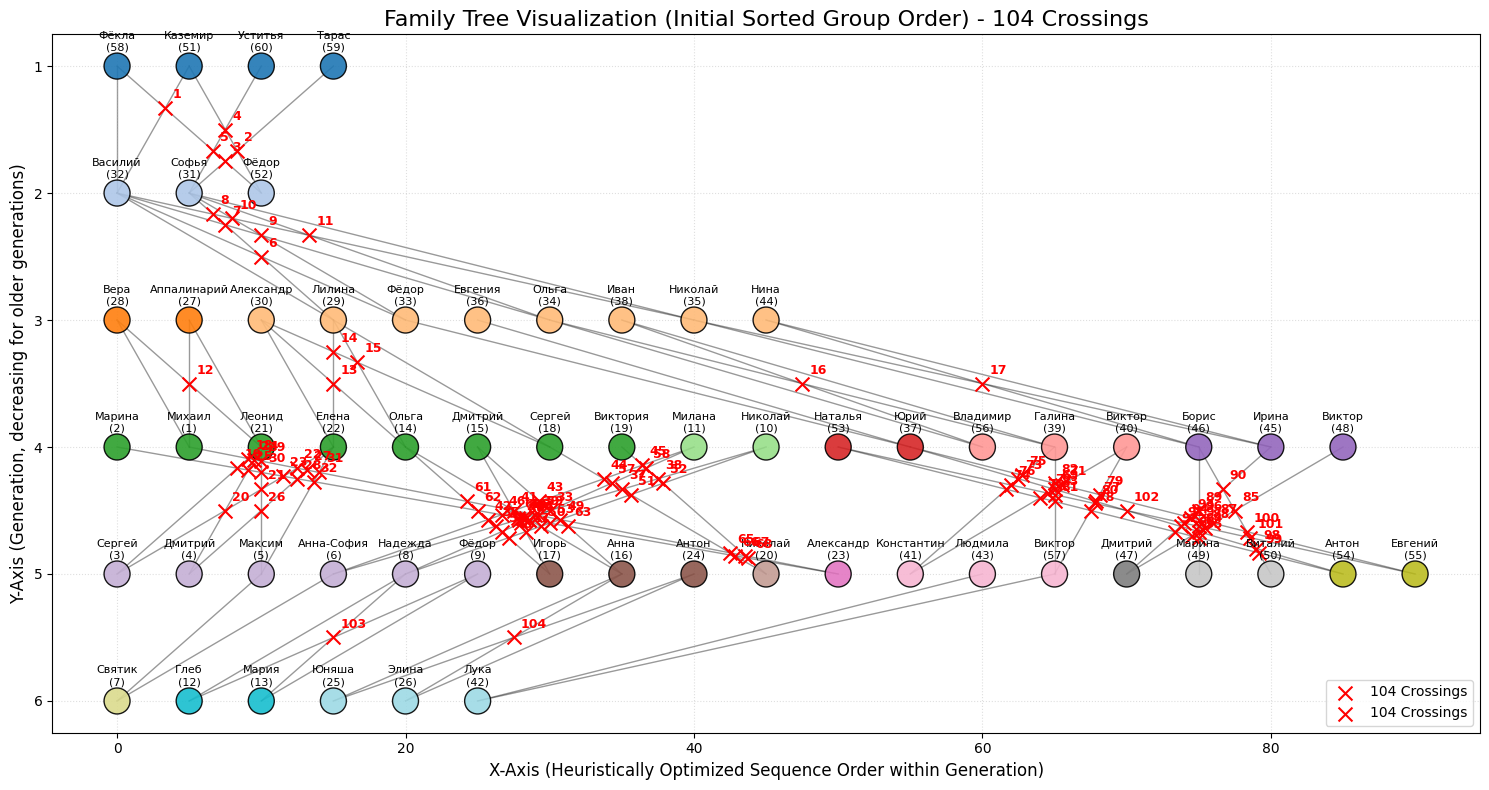

In [1]:
#cell 1
 
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import itertools
import math

# =========================
# CONFIGURATION
# =========================
# Construct the path to the data file:
# NOTE: This path assumes the script is run from a location where 'data_prep' is a sibling directory.
# Adjust as necessary for your environment.
DATA_FILE = os.path.join(os.path.pardir, 'data_prep', 'family_data.xlsx')
PERSON_ID_COLUMN = 'PersonID'
PARTNER_ID_COLUMN = 'PartnerID'
PARENT_COLUMNS = ['FatherID', 'MotherID']
NAME_RU_COLUMN = 'Name-ru'
# X-spacing for visualization
X_SPACING_UNIT = 5
# =========================
# HELPER FUNCTIONS (Code 1)
# =========================

def load_data(file_path):
    """
    Load data and ensure IDs are integers for processing. 
    Exits immediately if the file is not found.
    """
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        # Print error and exit the script
        print(f"FATAL ERROR: Data file '{file_path}' not found.")
        print("Please ensure the file is in the parent directory's 'data_prep' folder.")
        exit(1) # Exit with a non-zero code to indicate an error
    except Exception as e:
        # Handle other potential loading errors (e.g., corrupted file)
        print(f"FATAL ERROR: An unexpected error occurred while reading the Excel file: {e}")
        exit(1)

    # Ensure IDs are integers
    df[PERSON_ID_COLUMN] = df[PERSON_ID_COLUMN].astype(int)
    
    # Clean up partner/parent IDs (assuming they might be floats)
    for col in [PARTNER_ID_COLUMN] + PARENT_COLUMNS:
        if col in df.columns:
            # Simple conversion for single IDs
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
            df.loc[df[col] == 0, col] = np.nan # set 0 back to NaN
    
    # Ensure Name-ru exists, or fallback to 'Name'
    if NAME_RU_COLUMN not in df.columns:
        if 'Name' in df.columns:
            df[NAME_RU_COLUMN] = df['Name']
        else:
            df[NAME_RU_COLUMN] = df[PERSON_ID_COLUMN].astype(str) # Final fallback
    
    return df

def get_partner_id(df_ref, person_id):
    """Safely retrieves the integer partner ID if it exists and is in the dataframe."""
    row_match = df_ref[df_ref[PERSON_ID_COLUMN] == person_id]
    if row_match.empty:
        return None
        
    partner_val = row_match[PARTNER_ID_COLUMN].iloc[0]
    
    if pd.notna(partner_val):
        partner_id = int(partner_val)
        # Check if the partner ID actually exists in the PersonID column
        if partner_id in df_ref[PERSON_ID_COLUMN].values:
            return partner_id
    return None

def get_siblings_by_parent_ids(df_ref, person_id, generation):
    """
    Finds all people in the specified generation who share the same non-NaN parents
    as the given person_id. 
    """
    row_match = df_ref[df_ref[PERSON_ID_COLUMN] == person_id]
    if row_match.empty:
        return []
        
    row = row_match.iloc[0]
    father = row.get(PARENT_COLUMNS[0])
    mother = row.get(PARENT_COLUMNS[1])
    
    siblings_df = df_ref[df_ref['Generation'] == generation]
    
    # If no parents are known, the person is treated as their own group start
    if pd.isna(father) and pd.isna(mother):
        return [person_id] 
    
    # Filter based on known parents
    condition = (siblings_df['Generation'] == generation)
    
    # Build conditions robustly
    if pd.notna(father):
        condition &= (siblings_df[PARENT_COLUMNS[0]] == father)
    else:
        condition &= siblings_df[PARENT_COLUMNS[0]].isna()

    if pd.notna(mother):
        condition &= (siblings_df[PARENT_COLUMNS[1]] == mother)
    else:
        condition &= siblings_df[PARENT_COLUMNS[1]].isna()

    return siblings_df[condition][PERSON_ID_COLUMN].tolist()

def create_clan_groups(df, gen_num):
    """
    Groups people in a generation based on the iterative sibling/spouse connection rule.
    Returns a list of sets (unsorted groups).
    """
    gen_df = df[df['Generation'] == gen_num]
    gen_ids = set(gen_df[PERSON_ID_COLUMN].tolist())
    unprocessed_ids = gen_ids.copy()
    all_groups_sets = []
    
    while unprocessed_ids:
        start_id = min(unprocessed_ids) # Start with the lowest ID for determinism
        
        # --- 1. Find the initial sibling group ---
        initial_cluster = get_siblings_by_parent_ids(df, start_id, gen_num)
        
        current_group = set()
        queue = set()
        
        for p_id in initial_cluster:
            if p_id in unprocessed_ids:
                queue.add(p_id)
                current_group.add(p_id)
        
        if not queue:
            unprocessed_ids.discard(start_id)
            continue
            
        # --- 2-5. Iterative Expansion (BFS-like on partner/sibling connections) ---
        
        while queue:
            partners_added = set()
            
            # Phase 1: Expand Partners (Steps 2 & 4)
            # The queue contains siblings whose partners we must check
            for p_id in queue:
                partner = get_partner_id(df, p_id)
                if partner and partner in gen_ids and partner not in current_group:
                    current_group.add(partner)
                    partners_added.add(partner)

            # Phase 2: Expand Siblings of the new Partners (Steps 3 & 5)
            siblings_of_partners_added = set()
            
            for p_id in partners_added:
                # Find all siblings of the newly added partner
                partner_siblings = get_siblings_by_parent_ids(df, p_id, gen_num)
                for s_id in partner_siblings:
                    if s_id in gen_ids and s_id not in current_group:
                        current_group.add(s_id)
                        siblings_of_partners_added.add(s_id)
                        
            # The next queue contains the newly added siblings, whose partners will be checked next
            queue = siblings_of_partners_added.copy()

        # Group is stabilized, save it and update unprocessed list
        all_groups_sets.append(current_group)
        unprocessed_ids -= current_group

    return all_groups_sets

def group_people_by_siblings(df_ref, people_ids):
    """Identifies and groups people by their unique set of parents within the provided set of people."""
    sibling_sets = defaultdict(list)
    
    for person_id in people_ids:
        row_match = df_ref[df_ref[PERSON_ID_COLUMN] == person_id]
        if row_match.empty:
            continue
            
        row = row_match.iloc[0]
        father = row.get(PARENT_COLUMNS[0])
        mother = row.get(PARENT_COLUMNS[1])
        
        # Create a stable key for the parent set
        parent_key = tuple(sorted([
            int(father) if pd.notna(father) else 0,
            int(mother) if pd.notna(mother) else 0
        ]))
        
        # If no parents, use a unique key based on the person's ID (they are a family unit of 1)
        if parent_key == (0, 0):
            parent_key = (person_id, person_id) 

        sibling_sets[parent_key].append(person_id)
        
    return sibling_sets

def get_partner_in_group(df_ref, person_id, group_ids):
    """Safely retrieves the partner ID if it exists and is within the given group."""
    partner_id = get_partner_id(df_ref, person_id)
    return partner_id if partner_id and partner_id in group_ids else None

def sort_group_internally(df_ref, group_ids, gen_num):
    """
    Applied the user's complex conditional sorting logic within a single clan group.
    Returns the final ordered list of person IDs.
    """
    
    # 1. Map all people in the group to their sibling set key (parent_key)
    sibling_sets_map = group_people_by_siblings(df_ref, group_ids)
    
    final_sorted_group = []
    processed_ids = set()
    
    # Helper to add a person to the sorted list and processed set
    def _place_person(p_id):
        if p_id not in processed_ids:
            final_sorted_group.append(p_id)
            processed_ids.add(p_id)
    
    # Find the starting ID (lowest ID) and its parent key (Primary Family Unit Key)
    start_id = min(group_ids)
    
    primary_key = None
    for key, ids in sibling_sets_map.items():
        if start_id in ids:
            primary_key = key
            break
            
    if not primary_key:
        return sorted(list(group_ids)) # Fallback
    
    # Initialize queue for expansion (Steps 7-9)
    family_unit_keys_to_process = []
    queued_family_unit_keys = set()
    
    # --- PHASE 1: Process the Primary Family Unit (Conditional Start) ---
    
    current_key = primary_key
    primary_family_ids = sorted([p for p in sibling_sets_map.get(current_key, []) if p in group_ids])
    
    singles = []
    partnered_siblings = [] 
    
    # Separate the family unit members into Singles and Partnered Siblings
    for p_id in primary_family_ids:
        if p_id in processed_ids: continue
        
        partner_id = get_partner_in_group(df_ref, p_id, group_ids)
        
        if partner_id:
            # Use the lower ID to ensure we only process the couple once
            couple_key = tuple(sorted((p_id, partner_id)))
            if p_id == couple_key[0]: 
                partnered_siblings.append(p_id) 
        else:
            singles.append(p_id)

    # Sort partnered siblings by ID to identify the anchor
    partnered_siblings.sort() 
    anchor_sibling_id = partnered_siblings[0] if partnered_siblings else None
    
    partners_for_expansion = [] 
    
    # --- Case A: If there are singles (Logic 1-6) ---
    if singles:
        # Steps 1-3: Place all unpartnered siblings first
        for s_id in singles:
            _place_person(s_id)

        # Iterate through partnered siblings
        for p_id in partnered_siblings:
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if p_id not in processed_ids and partner_id and partner_id not in processed_ids:
                # Steps 4-6: Place Sibling, then Partner
                _place_person(p_id)
                _place_person(partner_id)
                
                # Queue partner's family key
                partner_key = None
                for key, ids in sibling_sets_map.items():
                    if partner_id in ids:
                        partner_key = key
                        break
                if partner_key and partner_key != current_key:
                    partners_for_expansion.append(partner_key)

    # --- Case B: If there are NO singles (Logic 1-2 from second list) ---
    elif partnered_siblings:
        for p_id in partnered_siblings:
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if p_id not in processed_ids and partner_id and partner_id not in processed_ids:
                is_anchor = (p_id == anchor_sibling_id)
                
                partner_key = None
                for key, ids in sibling_sets_map.items():
                    if partner_id in ids:
                        partner_key = key
                        break
                
                # Step 1: Anchor Sibling Rule: Place Partner, then Sibling
                if is_anchor:
                    _place_person(partner_id) 
                    _place_person(p_id) 
                    
                # Steps 5-6/Step 2: Regular Rule: Place Sibling, then Partner
                else:
                    _place_person(p_id) 
                    _place_person(partner_id)
                
                # Queue partner's family key for expansion (Steps 7-9)
                if partner_key and partner_key != current_key:
                    partners_for_expansion.append(partner_key)


    # --- PHASE 2: Populate Initial Queue for Expansion (Steps 7-9) ---
    
    if partners_for_expansion:
        # Ensure anchor's partner's family is processed first (Steps 7-8)
        anchor_partner_key = partners_for_expansion[0]
        if anchor_partner_key not in queued_family_unit_keys:
            family_unit_keys_to_process.append(anchor_partner_key)
            queued_family_unit_keys.add(anchor_partner_key)
            
        # Process remaining partners' families (Step 9)
        for other_partner_key in partners_for_expansion[1:]:
            if other_partner_key not in queued_family_unit_keys:
                family_unit_keys_to_process.append(other_partner_key)
                queued_family_unit_keys.add(other_partner_key)

    # --- PHASE 3: Process Secondary Family Units (Looping through the queue) ---
    
    current_key_index = 0
    while current_key_index < len(family_unit_keys_to_process) and len(processed_ids) < len(group_ids):
        current_key = family_unit_keys_to_process[current_key_index]
        current_key_index += 1 # Advance pointer immediately

        current_family_ids = sorted([p for p in sibling_sets_map.get(current_key, []) if p in group_ids])
        
        # 1. Separate members again
        secondary_singles = []
        secondary_partnered_siblings = [] 

        for p_id in current_family_ids:
            if p_id in processed_ids: continue
            
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if partner_id:
                couple_key = tuple(sorted((p_id, partner_id)))
                if p_id == couple_key[0]: 
                    secondary_partnered_siblings.append(p_id) 
            else:
                secondary_singles.append(p_id)

        # 2. Place Singles first
        for s_id in secondary_singles:
            _place_person(s_id)

        # 3. Place Couples (Sibling, then Partner) and queue new partners
        for p_id in secondary_partnered_siblings:
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if p_id not in processed_ids and partner_id and partner_id not in processed_ids:
                
                _place_person(p_id)
                _place_person(partner_id)

                # Queue partner's family key (Steps 7-9 again for subsequent levels of expansion)
                partner_key = None
                for key, ids in sibling_sets_map.items():
                    if partner_id in ids:
                        partner_key = key
                        break
                        
                if partner_key and partner_key != current_key and partner_key not in queued_family_unit_keys:
                    family_unit_keys_to_process.append(partner_key)
                    queued_family_unit_keys.add(partner_key)

    # Add any truly remaining, unplaced people (e.g., if they were isolated singles)
    remaining = [p for p in group_ids if p not in processed_ids]
    final_sorted_group.extend(sorted(remaining)) 
    
    return final_sorted_group

# =========================
# MAIN EXECUTION (Code 1)
# =========================

# Load and prepare data - Will now exit if file is not found
df = load_data(DATA_FILE)

# Initialize storage for all sorted groups: {generation: [list_of_group_1_IDs, list_of_group_2_IDs, ...]}
all_sorted_groups_by_gen = {} 

# Identify generations
generations = sorted(df['Generation'].unique())
name_map = df.set_index(PERSON_ID_COLUMN)[NAME_RU_COLUMN].to_dict()

print("--- Clan Grouping and Complex Internal Sorting Results ---")

for gen_num in generations:
    if gen_num == 0: continue
        
    # 1. Create the large clan groups (unsorted sets of IDs)
    groups_sets = create_clan_groups(df, gen_num)
    
    print(f"\n======================================")
    print(f"=== Generation {gen_num} ({len(groups_sets)} Groups) ===")
    print(f"======================================")
    
    # List to hold the sorted lists for the current generation
    sorted_groups_for_gen = []
    
    for i, group_ids_set in enumerate(groups_sets):
        # 2. Sort the group internally (returns the ordered list)
        sorted_group = sort_group_internally(df, group_ids_set, gen_num)

        # 3. Store the sorted group list
        sorted_groups_for_gen.append(sorted_group)

        # 4. Print the sorted results
        group_details = [f"ID {p}: {name_map.get(p, 'N/A')}" for p in sorted_group]
        print(f"Group {i+1} ({len(sorted_group)} people):")
        for detail in group_details:
            print(f"  - {detail}")
        print("-" * 20)

    # Save the complete list of ordered groups for this generation
    all_sorted_groups_by_gen[gen_num] = sorted_groups_for_gen

print("\n--- Starting Visualization ---")

# =========================
# VISUALIZATION HELPER FUNCTIONS (Code 2)
# =========================

def calculate_intersection_point(P1_coord, C1_coord, P2_coord, C2_coord, y_parent, y_child):
    """
    Calculates the intersection point of two line segments (P1->C1) and (P2->C2)
    spanning the same two generations (y_parent and y_child).
    
    Returns (x_i, y_i) if they cross within the segments, otherwise None.
    """
    x_p1, x_c1 = P1_coord[0], C1_coord[0]
    x_p2, x_c2 = P2_coord[0], C2_coord[0]

    # Check for crossing of X-coordinates: (P1 is left of P2 AND C1 is right of C2) OR vice versa
    if (x_p1 < x_p2 and x_c1 > x_c2) or (x_p1 > x_p2 and x_c1 < x_c2):
        
        # Denominator: (x_p1 - x_p2) - (x_c1 - x_c2)
        denominator = (x_p1 - x_p2) - (x_c1 - x_c2)
        
        # If denominator is near zero, lines are parallel or collinear (should not happen with unique coordinates)
        if abs(denominator) < 1e-9:
            return None 

        # Numerator: x_p1 - x_p2
        numerator = x_p1 - x_p2
        
        k = numerator / denominator

        # Check if intersection occurs within the segment bounds (0 < k < 1)
        if 0 < k < 1:
            # Calculate intersection coordinates (X_I, Y_I)
            x_i = x_p1 + k * (x_c1 - x_p1)
            y_i = y_parent + k * (y_child - y_parent)
            
            return (x_i, y_i)
            
    return None

# =========================
# VISUALIZATION EXECUTION (Code 2)
# =========================

# Use the result from the sorting in Code 1
groups_source = all_sorted_groups_by_gen

plot_data = []
global_group_color_index = 0 # Unique index for coloring groups

for gen, ordered_groups in sorted(groups_source.items()):
    # Y position is based on generation (older generations on top, lower Y value)
    y_coord = -gen * 10
    x_position_in_gen = 0
    
    for group in ordered_groups:
        for person_id in group:
            # Find the person's row in the main DataFrame
            row_match = df[df[PERSON_ID_COLUMN] == person_id]
            
            if not row_match.empty:
                row = row_match.iloc[0]
                
                plot_data.append({
                    'PersonID': person_id,
                    # Fallback to ID if name is missing
                    'Name-ru': row.get(NAME_RU_COLUMN, f"ID {person_id}"), 
                    'Generation': gen,
                    'x': x_position_in_gen * X_SPACING_UNIT, 
                    'y': y_coord,
                    'GroupColorIndex': global_group_color_index # Assign the unique color index
                })
                x_position_in_gen += 1 
        
        global_group_color_index += 1 # Increment group color index after processing a group

# Create the final plotting DataFrame
final_coordinates_data = pd.DataFrame(plot_data)

if final_coordinates_data.empty:
    print("No coordinate data to plot.")
    exit(0) # Exit gracefully if no data

# --- 2. Extract plotting columns and Coordinates Map and Collect Segments ---
x_coords = final_coordinates_data['x']
y_coords = final_coordinates_data['y']
group_color_indices = final_coordinates_data['GroupColorIndex'] 

# Create a map for fast coordinate lookups by PersonID
coord_map = final_coordinates_data.set_index('PersonID')[['x', 'y']].to_dict('index')

# List to store all parent-child line segments
all_segments = []
# List to store intersection points
intersection_points = []


# Collect all segments and find intersections
# We need a list of all connections (ChildID, ParentID, Y_Gen)
for _, row in final_coordinates_data.iterrows():
    child_id = row['PersonID']
    child_gen = row['Generation']
    child_coord = (row['x'], row['y'])
    
    original_row_match = df[df[PERSON_ID_COLUMN] == child_id]
    
    if not original_row_match.empty:
        original_row = original_row_match.iloc[0]
        
        for parent_col in PARENT_COLUMNS:
            parent_id = original_row.get(parent_col)
            
            if pd.notna(parent_id) and int(parent_id) in coord_map:
                parent_id = int(parent_id)
                parent_coord = (coord_map[parent_id]['x'], coord_map[parent_id]['y'])
                
                # Check if this connection spans adjacent generations
                if coord_map[parent_id]['y'] != coord_map[child_id]['y']:
                    # Store as (ParentID, ChildID, ParentCoord, ChildCoord, ParentY)
                    all_segments.append((parent_id, child_id, parent_coord, child_coord, parent_coord[1]))


# --- 3. Find Intersections ---

# Group segments by the Y-coordinate of the parent (which defines the generation pair)
segments_by_gen_pair = {}
for p_id, c_id, p_coord, c_coord, p_y in all_segments:
    if p_y not in segments_by_gen_pair:
        segments_by_gen_pair[p_y] = []
    segments_by_gen_pair[p_y].append({
        'P_ID': p_id, 'C_ID': c_id, 
        'P_COORD': p_coord, 'C_COORD': c_coord
    })

for y_parent, segments in segments_by_gen_pair.items():
    if len(segments) < 2:
        continue
        
    y_child = segments[0]['C_COORD'][1] # All children in this group share the same Y
    
    # Iterate through all unique pairs of segments in this generation pair
    for seg_a, seg_b in itertools.combinations(segments, 2):
        P1 = seg_a['P_COORD']
        C1 = seg_a['C_COORD']
        P2 = seg_b['P_COORD']
        C2 = seg_b['C_COORD']
        
        # Calculate intersection
        intersection = calculate_intersection_point(P1, C1, P2, C2, y_parent, y_child)
        
        if intersection:
            # We found a crossing. Only add unique intersection points.
            if intersection not in intersection_points:
                intersection_points.append(intersection)

# --- 4. Create the Scatter Plot ---
plt.figure(figsize=(15, 8))
ax = plt.gca()

# --- 4a. Draw Connections (Lines) ---
for _, row in final_coordinates_data.iterrows():
    child_id = row['PersonID']
    child_x, child_y = row['x'], row['y']
    
    original_row_match = df[df[PERSON_ID_COLUMN] == child_id]
    
    if not original_row_match.empty:
        original_row = original_row_match.iloc[0]
        
        # Draw connections to both parents
        for parent_col in PARENT_COLUMNS:
            parent_id = original_row.get(parent_col)
            
            # Ensure parent_id is valid and in our plotted coordinate map
            if pd.notna(parent_id) and int(parent_id) in coord_map:
                parent_id = int(parent_id)
                parent_x, parent_y = coord_map[parent_id]['x'], coord_map[parent_id]['y']
                
                # Draw line from child to parent
                ax.plot([child_x, parent_x], [child_y, parent_y], 
                        'k-', alpha=0.4, linewidth=1, zorder=1) 


# --- 4b. Draw Intersections ---
if intersection_points:
    ix_x = [p[0] for p in intersection_points]
    ix_y = [p[1] for p in intersection_points]
    
    # Plot intersection points as large red markers
    ax.scatter(ix_x, ix_y, 
                c='red', marker='x', s=100, 
                label=f'{len(intersection_points)} Crossings', zorder=3)
                
    # Annotate with numbers
    for i, (x_i, y_i) in enumerate(intersection_points):
        ax.annotate(
            str(i + 1),
            (x_i, y_i),
            textcoords="offset points",
            xytext=(5, 5), # Slightly offset text
            ha='left',
            va='bottom',
            fontsize=9,
            color='red',
            fontweight='bold',
            zorder=4
        )
    print(f"Total line crossings found and marked: {len(intersection_points)}")


# --- 4c. Draw Nodes (Points) ---
scatter = ax.scatter(
    x_coords,
    y_coords,
    # Color based on the unique GroupColorIndex
    c=group_color_indices, 
    cmap='tab20', # 'tab20' is a good colormap for discrete, distinct colors
    s=350,  
    alpha=0.9, 
    edgecolors='black',
    linewidths=1.0,
    zorder=2 
)


# --- 5. Add Annotations: Name and PersonID ---
for i, row in final_coordinates_data.iterrows():
    # Annotate with the Name-ru and PersonID
    plt.annotate(
        f"{row['Name-ru']}\n({row['PersonID']})", 
        (row['x'], row['y']),
        textcoords="offset points",
        xytext=(0, 10), # Offset text 10 points above the node
        ha='center',
        va='bottom', # Align text to the bottom of the offset
        fontsize=8,
        color='black' # BLACK TEXT
    )

# --- 6. Final Touches ---
plt.title(f"Family Tree Visualization (Initial Sorted Group Order) - {len(intersection_points)} Crossings", fontsize=16)
plt.xlabel("X-Axis (Heuristically Optimized Sequence Order within Generation)", fontsize=12)
plt.ylabel("Y-Axis (Generation, decreasing for older generations)", fontsize=12)

# Adjust axes and layout
ax.set_aspect('auto', adjustable='box') # Changed to auto for better layout in general cases
ax.grid(True, linestyle=':', alpha=0.4)
ax.set_yticks(sorted(final_coordinates_data['y'].unique()))
ax.set_yticklabels(sorted(final_coordinates_data['Generation'].unique(), reverse=True))
# Create a dummy legend handle for the crossings count
if intersection_points:
    # Adding a simple proxy artist for the legend entry for 'Crossings'
    ax.scatter([], [], c='red', marker='x', s=100, label=f'{len(intersection_points)} Crossings')
    
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Cell 2 - collapsing groups ####


--- Combined Dataset df_combined Created ---
Total Combined Entities: 22

--- Detailed Group Information and Connections ---

Group Name: Группа 6-1 (Святик) (New ID: 1060)
  Generation: 6
  Total People: 1
  People IDs: [7]
  People Names: ['Святик']
  -------------------
  Incoming Connections:
    Parent 1: Group ID 1064 (Группа 5-1 (Сергей))
    Parent 2: Group ID 1064 (Группа 5-1 (Сергей))
  Outgoing Children Groups (0):
    N/A

Group Name: Группа 6-2 (Глеб) (New ID: 1061)
  Generation: 6
  Total People: 2
  People IDs: [12, 13]
  People Names: ['Глеб', 'Мария']
  -------------------
  Incoming Connections:
    Parent 1: Group ID 1064 (Группа 5-1 (Сергей))
    Parent 2: Group ID 1064 (Группа 5-1 (Сергей))
  Outgoing Children Groups (0):
    N/A

Group Name: Группа 6-3 (Юняша) (New ID: 1062)
  Generation: 6
  Total People: 2
  People IDs: [25, 26]
  People Names: ['Юняша', 'Элина']
  -------------------
  Incoming Connections:
    Parent 1: Group ID 1065 (Группа 5-2 (Игорь))
    

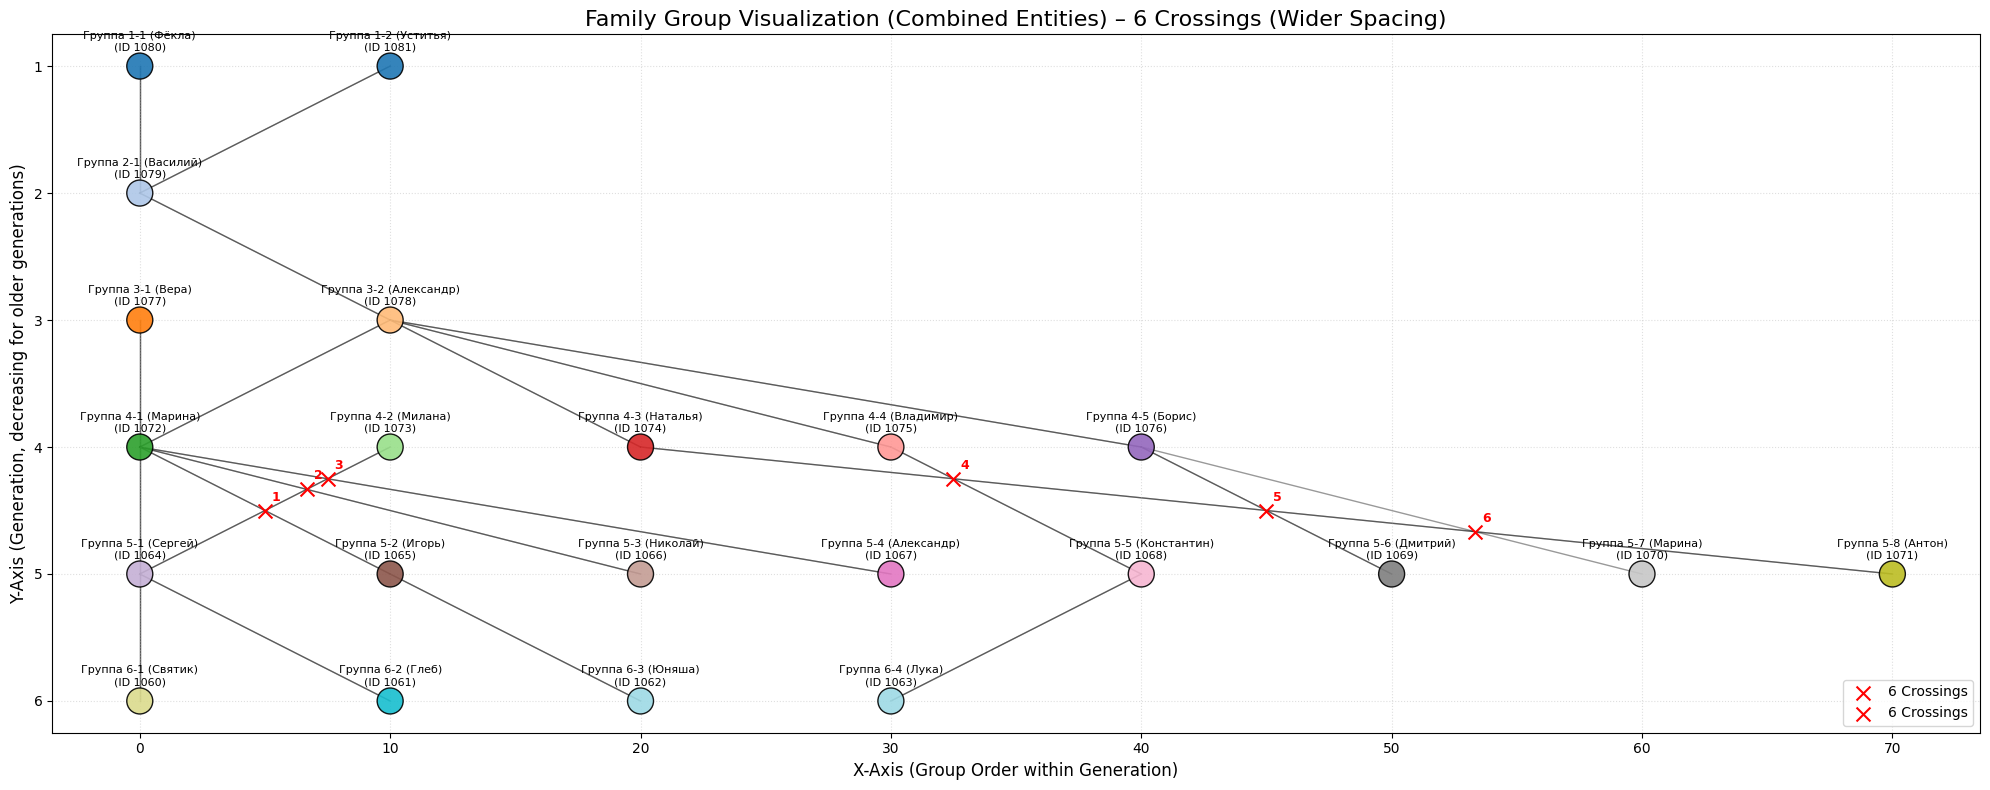

In [2]:
#cell 2

# =============================================================
# COMBINED SCRIPT: GROUP AGGREGATION AND VISUALIZATION
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math

# =============================================================
# HELPER FUNCTION: Intersection Calculation (from Code 2)
# =============================================================

def calculate_intersection_point(P1_coord, C1_coord, P2_coord, C2_coord, y_parent, y_child):
    """Find intersection between two segments (P1→C1) and (P2→C2) across generations."""
    x_p1, x_c1 = P1_coord[0], C1_coord[0]
    x_p2, x_c2 = P2_coord[0], C2_coord[0]

    # Check crossing direction
    if (x_p1 < x_p2 and x_c1 > x_c2) or (x_p1 > x_p2 and x_c1 < x_c2):
        denominator = (x_p1 - x_p2) - (x_c1 - x_c2)
        if abs(denominator) < 1e-9:
            return None

        numerator = x_p1 - x_p2
        k = numerator / denominator
        if 0 < k < 1:
            x_i = x_p1 + k * (x_c1 - x_p1)
            y_i = y_parent + k * (y_child - y_parent)
            return (x_i, y_i)
    return None

# =============================================================
# DATA AGGREGATION AND REMAPPING (from Code 1)
# =============================================================

# --- Configuration & Initialization (assuming variables from previous cell exist) ---
if 'df' not in globals() or 'all_sorted_groups_by_gen' not in globals():
    raise NameError("Required variables (df, all_sorted_groups_by_gen, etc.) from previous steps are missing. Please ensure those cells were executed.")

MAX_ORIGINAL_ID = df[PERSON_ID_COLUMN].max()
NEW_ID_START = MAX_ORIGINAL_ID + 1000

new_data_records = []
current_new_id = NEW_ID_START

original_to_new_id_map = {}
original_groups_count = 0
# This variable is crucial for the visualization part of Code 2
combined_groups_for_viz = {} 

# ---------- Stage 1: Combine groups (reverse generation order) ----------
for gen_num, list_of_groups in sorted(all_sorted_groups_by_gen.items(), key=lambda item: item[0], reverse=True):
    original_groups_count += len(list_of_groups)
    combined_groups_for_gen = []

    for group_index, group_ids in enumerate(list_of_groups):
        combined_id = current_new_id
        current_new_id += 1
        # Store the new combined_id for visualization mapping
        combined_groups_for_gen.append([combined_id]) 

        for pid in group_ids:
            original_to_new_id_map[int(pid)] = combined_id

        anchor_person_id = group_ids[0]
        anchor_name = name_map.get(anchor_person_id, f"ID {anchor_person_id}")
        combined_name = f"Группа {gen_num}-{group_index+1} ({anchor_name})"

        # Collect ALL external partners + all parents (original ID space)
        external_partners, fathers, mothers = set(), set(), set()

        for pid in group_ids:
            row = df.loc[df[PERSON_ID_COLUMN] == pid]
            if row.empty:
                continue
            row = row.iloc[0]

            # Partner
            partner_id = row.get(PARTNER_ID_COLUMN)
            if pd.notna(partner_id):
                partner_id = int(partner_id)
                # Only care about partners outside the current group
                if partner_id not in group_ids: 
                    external_partners.add(partner_id)

            # Parents
            father = row.get(PARENT_COLUMNS[0])
            mother = row.get(PARENT_COLUMNS[1])
            if pd.notna(father) and int(father) != 0:
                fathers.add(int(father))
            if pd.notna(mother) and int(mother) != 0:
                mothers.add(int(mother))

        new_record = {
            PERSON_ID_COLUMN: combined_id,
            NAME_RU_COLUMN: combined_name,
            "OriginalGroupIDs": list(group_ids),
            # Use lists for multiple connections, NaN if none
            PARTNER_ID_COLUMN: sorted(list(external_partners)) if external_partners else np.nan,
            PARENT_COLUMNS[0]: sorted(list(fathers)) if fathers else np.nan,
            PARENT_COLUMNS[1]: sorted(list(mothers)) if mothers else np.nan,
            "Generation": gen_num,
        }
        new_data_records.append(new_record)

    combined_groups_for_viz[gen_num] = combined_groups_for_gen

df_combined_temp = pd.DataFrame(new_data_records)

# ---------- Stage 2: Remap IDs (handle lists properly) ----------
def remap_any(val):
    """Remaps individual or list of original IDs to new combined IDs."""
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return np.nan

    # Handle list-like values (multiple IDs)
    if isinstance(val, (list, set, tuple, np.ndarray)):
        mapped = []
        for orig in val:
            if orig is None or (isinstance(orig, float) and pd.isna(orig)):
                continue
            try:
                orig_int = int(orig)
            except Exception:
                continue
            new_id = original_to_new_id_map.get(orig_int)
            if new_id is not None:
                mapped.append(int(new_id))
        return sorted(set(mapped)) if mapped else np.nan

    # Handle single scalar values
    try:
        orig_int = int(val)
    except Exception:
        return np.nan

    return original_to_new_id_map.get(orig_int, np.nan)


for col in [PARTNER_ID_COLUMN] + PARENT_COLUMNS:
    df_combined_temp[col] = df_combined_temp[col].apply(remap_any)

# Remove self-links (a group pointing to itself)
def remove_self_refs(row):
    """Removes the combined group's ID from its own connection lists."""
    cid = int(row[PERSON_ID_COLUMN])
    for col in [PARTNER_ID_COLUMN] + PARENT_COLUMNS:
        v = row[col]
        if isinstance(v, list):
            v = [x for x in v if x != cid]
            row[col] = v if v else np.nan
        elif pd.notna(v) and int(v) == cid:
            row[col] = np.nan
    return row

df_combined_temp = df_combined_temp.apply(remove_self_refs, axis=1)

# ---------- Stage 3: Final DataFrame `df_combined` ----------
df_combined = df_combined_temp[
    [
        PERSON_ID_COLUMN,
        NAME_RU_COLUMN,
        "Generation",
        PARTNER_ID_COLUMN,
        PARENT_COLUMNS[0],
        PARENT_COLUMNS[1],
        "OriginalGroupIDs",
    ]
].copy()

df_combined[PERSON_ID_COLUMN] = df_combined[PERSON_ID_COLUMN].astype(int)

# ---------- Stage 4: Build child (outgoing) connections for detailed printout ----------
child_connections = {gid: set() for gid in df_combined[PERSON_ID_COLUMN].unique()}

for _, row in df_combined.iterrows():
    child_id = int(row[PERSON_ID_COLUMN])
    for pcol in PARENT_COLUMNS:
        parents = row[pcol]
        if isinstance(parents, list):
            for pid in parents:
                if pd.notna(pid) and pid in child_connections:
                    child_connections[pid].add(child_id)
        elif pd.notna(parents) and int(parents) in child_connections:
            child_connections[int(parents)].add(child_id)

child_connections = {k: sorted(list(v)) for k, v in child_connections.items() if v}

print("\n--- Combined Dataset df_combined Created ---")
print(f"Total Combined Entities: {len(df_combined)}")

# ---------- Stage 5: PRINT RESULTS (from Code 1) ----------
print("\n" + "=" * 40)
print("--- Detailed Group Information and Connections ---")

def get_connection_name(conn_id, is_child=False):
    """Looks up and formats the name of a connected group."""
    if pd.isna(conn_id):
        return "N/A"
    conn_id = int(conn_id)
    conn_row = df_combined[df_combined[PERSON_ID_COLUMN] == conn_id]
    if not conn_row.empty:
        label = "Child Group" if is_child else "Group"
        return f"{label} ID {conn_id} ({conn_row.iloc[0][NAME_RU_COLUMN]})"
    return f"ID {conn_id} (Unresolved/Missing Group)"

for _, row in df_combined.iterrows():
    group_id = int(row[PERSON_ID_COLUMN])
    group_ids = row["OriginalGroupIDs"]
    people_names = [name_map.get(pid, f"Name not found for ID {pid}") for pid in group_ids]

    # Incoming / lateral connections
    incoming_connections_list = []
    for i, pcol in enumerate(PARENT_COLUMNS, start=1):
        parents = row[pcol]
        if isinstance(parents, list):
            for pid in parents:
                incoming_connections_list.append(f"Parent {i}: {get_connection_name(pid)}")
        elif pd.notna(parents):
            incoming_connections_list.append(f"Parent {i}: {get_connection_name(parents)}")

    partners = row[PARTNER_ID_COLUMN]
    if isinstance(partners, list):
        for pid in partners:
            incoming_connections_list.append(f"Partner: {get_connection_name(pid)}")
    elif pd.notna(partners):
        incoming_connections_list.append(f"Partner: {get_connection_name(partners)}")

    # Outgoing children
    outgoing_connections_list = []
    for cid in child_connections.get(group_id, []):
        outgoing_connections_list.append(get_connection_name(cid, is_child=True))

    print(f"\nGroup Name: {row[NAME_RU_COLUMN]} (New ID: {group_id})")
    print(f"  Generation: {int(row['Generation'])}")
    print(f"  Total People: {len(group_ids)}")
    print(f"  People IDs: {group_ids}")
    print(f"  People Names: {people_names}")
    print(f"  -------------------")
    print("  Incoming Connections:")
    if incoming_connections_list:
        print("    " + "\n    ".join(incoming_connections_list))
    else:
        print("    N/A")
    print(f"  Outgoing Children Groups ({len(outgoing_connections_list)}):")
    if outgoing_connections_list:
        print("    " + "\n    ".join(outgoing_connections_list))
    else:
        print("    N/A")

print("\n" + "=" * 40)
final_groups_count = len(df_combined)
print("--- Group Count Summary ---")
print(f"Original Total Number of Groups: {original_groups_count}")
print(f"Final Total Number of Entities in df_combined: {final_groups_count}")
print("=" * 40)

# =============================================================
# VISUALIZATION (from Code 2)
# =============================================================

# --- 1. Prepare Data for Plotting ---
groups_source = combined_groups_for_viz
df_plot = df_combined # Use the newly created combined dataframe

plot_data = []
X_SPACING_UNIT = 10
FIGURE_WIDTH = 20
FIGURE_HEIGHT = 8

global_group_color_index = 0

for gen, ordered_groups in sorted(groups_source.items()):
    y_coord = -gen * 10
    x_position_in_gen = 0

    for group_list in ordered_groups:
        combined_id = group_list[0]
        row_match = df_plot[df_plot[PERSON_ID_COLUMN] == combined_id]

        if not row_match.empty:
            row = row_match.iloc[0]
            plot_data.append({
                'PersonID': combined_id,
                'Name-ru': row.get(NAME_RU_COLUMN, f"ID {combined_id}"),
                'Generation': gen,
                'x': x_position_in_gen * X_SPACING_UNIT,
                'y': y_coord,
                'GroupColorIndex': global_group_color_index
            })
            x_position_in_gen += 1
        global_group_color_index += 1

final_coordinates_data = pd.DataFrame(plot_data)

if final_coordinates_data.empty:
    print("No coordinate data to plot.")
else:
    # --- 2. Coordinate Mapping and Segments ---
    x_coords = final_coordinates_data['x']
    y_coords = final_coordinates_data['y']
    group_color_indices = final_coordinates_data['GroupColorIndex']

    coord_map = final_coordinates_data.set_index('PersonID')[['x', 'y']].to_dict('index')

    all_segments = []
    intersection_points = []

    # Collect all parent-child connections
    for _, row in final_coordinates_data.iterrows():
        child_id = row['PersonID']
        combined_row_match = df_plot[df_plot[PERSON_ID_COLUMN] == child_id]
        if combined_row_match.empty:
            continue
        combined_row = combined_row_match.iloc[0]

        for parent_col in PARENT_COLUMNS:
            parent_val = combined_row.get(parent_col)
            
            # Robust handling for scalar / list / NaN
            if isinstance(parent_val, (list, set, tuple, np.ndarray)):
                parent_val = [p for p in parent_val if pd.notna(p)]
            elif pd.notna(parent_val):
                parent_val = [parent_val]
            else:
                continue

            # Iterate through all possible parents (if multiple)
            for parent_id in parent_val:
                try:
                    parent_id = int(parent_id)
                except Exception:
                    continue

                if parent_id in coord_map:
                    parent_coord = (coord_map[parent_id]['x'], coord_map[parent_id]['y'])
                    child_coord = (coord_map[child_id]['x'], coord_map[child_id]['y'])

                    if parent_coord[1] != child_coord[1]:
                        all_segments.append(
                            (parent_id, child_id, parent_coord, child_coord, parent_coord[1])
                        )


    # --- 3. Detect Line Intersections ---
    segments_by_gen_pair = {}
    for p_id, c_id, p_coord, c_coord, p_y in all_segments:
        if p_y not in segments_by_gen_pair:
            segments_by_gen_pair[p_y] = []
        segments_by_gen_pair[p_y].append({
            'P_ID': p_id, 'C_ID': c_id,
            'P_COORD': p_coord, 'C_COORD': c_coord
        })

    for y_parent, segments in segments_by_gen_pair.items():
        if len(segments) < 2:
            continue
        y_child = segments[0]['C_COORD'][1]

        for seg_a, seg_b in itertools.combinations(segments, 2):
            P1 = seg_a['P_COORD']
            C1 = seg_a['C_COORD']
            P2 = seg_b['P_COORD']
            C2 = seg_b['C_COORD']
            intersection = calculate_intersection_point(P1, C1, P2, C2, y_parent, y_child)
            if intersection and intersection not in intersection_points:
                intersection_points.append(intersection)

    print(f"\nTotal line crossings found and marked: {len(intersection_points)}")

    # --- 4. Plotting ---
    plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    ax = plt.gca()

    # 4a. Draw parent-child connections
    for _, row in final_coordinates_data.iterrows():
        child_id = row['PersonID']
        child_x, child_y = row['x'], row['y']
        combined_row_match = df_plot[df_plot[PERSON_ID_COLUMN] == child_id]
        if combined_row_match.empty:
            continue
        combined_row = combined_row_match.iloc[0]

        for parent_col in PARENT_COLUMNS:
            parent_val = combined_row.get(parent_col)
            
            # Robust handling
            if isinstance(parent_val, (list, set, tuple, np.ndarray)):
                parent_val = [p for p in parent_val if pd.notna(p)]
            elif pd.notna(parent_val):
                parent_val = [parent_val]
            else:
                continue
                
            for parent_id in parent_val:
                try:
                    parent_id = int(parent_id)
                except Exception:
                    continue

                if parent_id in coord_map:
                    parent_x, parent_y = coord_map[parent_id]['x'], coord_map[parent_id]['y']
                    ax.plot([child_x, parent_x], [child_y, parent_y],
                            'k-', alpha=0.4, linewidth=1, zorder=1)


    # 4b. Mark intersections
    if intersection_points:
        ix_x = [p[0] for p in intersection_points]
        ix_y = [p[1] for p in intersection_points]
        # Plot intersection points
        ax.scatter(ix_x, ix_y, c='red', marker='x', s=100,
                   label=f'{len(intersection_points)} Crossings', zorder=3)

        # Annotate with numbers
        for i, (x_i, y_i) in enumerate(intersection_points):
            ax.annotate(str(i + 1), (x_i, y_i),
                        textcoords="offset points", xytext=(5, 5),
                        ha='left', va='bottom', fontsize=9,
                        color='red', fontweight='bold', zorder=4)

    # 4c. Draw nodes
    scatter = ax.scatter(
        x_coords, y_coords,
        c=group_color_indices, cmap='tab20',
        s=350, alpha=0.9, edgecolors='black',
        linewidths=1.0, zorder=2
    )

    # --- 5. Labels and Layout ---
    for _, row in final_coordinates_data.iterrows():
        # Annotation includes the combined group name and its new ID
        plt.annotate(
            f"{row['Name-ru']}\n(ID {row['PersonID']})",
            (row['x'], row['y']),
            textcoords="offset points", xytext=(0, 10),
            ha='center', va='bottom', fontsize=8, color='black'
        )

    plt.title(f"Family Group Visualization (Combined Entities) – {len(intersection_points)} Crossings (Wider Spacing)",
              fontsize=16)
    plt.xlabel("X-Axis (Group Order within Generation)", fontsize=12)
    plt.ylabel("Y-Axis (Generation, decreasing for older generations)", fontsize=12)

    ax.set_aspect('auto', adjustable='box')
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.set_yticks(sorted(final_coordinates_data['y'].unique()))
    ax.set_yticklabels(sorted(final_coordinates_data['Generation'].unique(), reverse=True))

    # Ensure the legend includes the crossings count if present
    if intersection_points:
        ax.scatter([], [], c='red', marker='x', s=100, label=f'{len(intersection_points)} Crossings')

    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

### Cell 3 - reorder groups to reduce intersections ###

Total intersections before optimization: 22

--- Working on Generation 1 vs next generation 2 ---
  No intersections remaining.
Finished Generation 1: intersections now 0 (was 0)
----------------------------------------
--- Working on Generation 2 vs next generation 3 ---
  No intersections remaining.
Finished Generation 2: intersections now 0 (was 0)
----------------------------------------
--- Working on Generation 3 vs next generation 4 ---
  No intersections remaining.
Finished Generation 3: intersections now 0 (was 0)
----------------------------------------
--- Working on Generation 4 vs next generation 5 ---
    → Moved ID 1073 (Gen 4): x 10 → -10
      Intersections improved: 22 → 10

    → Moved ID 1075 (Gen 4): x 30 → 10
      Intersections improved: 10 → 6

    → Moved ID 1069 (Gen 5): x 50 → 80
      Intersections improved: 6 → 2

    → Moved ID 1070 (Gen 5): x 60 → 90
      Intersections improved: 2 → 0

  No intersections remaining.
Finished Generation 4: intersections no

C:\Users\savch\AppData\Local\Temp\ipykernel_4596\282166459.py:407: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


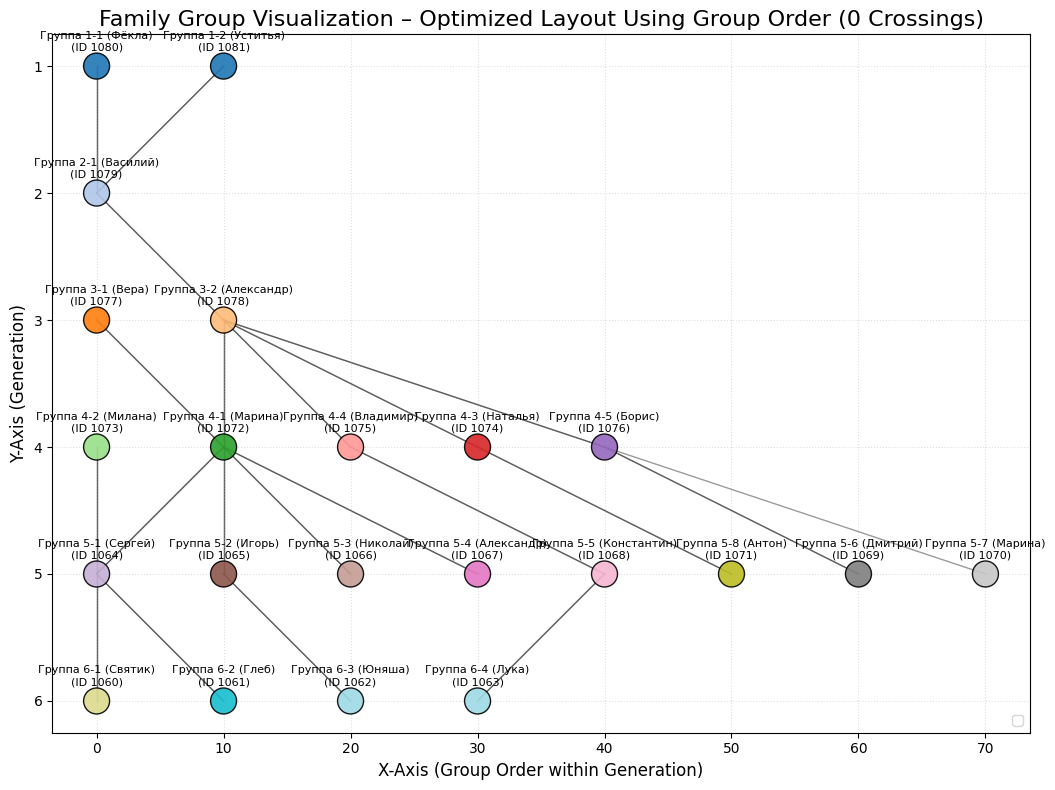

In [3]:
#cell 3

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# =============================================================
# GLOBAL HELPER FUNCTIONS
# =============================================================

# --- Helper: intersection counting (from Code 1)
def calculate_intersection_point(P1_coord, C1_coord, P2_coord, C2_coord, y_parent, y_child):
    x_p1, x_c1 = P1_coord[0], C1_coord[0]
    x_p2, x_c2 = P2_coord[0], C2_coord[0]

    if (x_p1 < x_p2 and x_c1 > x_c2) or (x_p1 > x_p2 and x_c1 < x_c2):
        denominator = (x_p1 - x_p2) - (x_c1 - x_c2)
        if abs(denominator) < 1e-9:
            return None
        numerator = x_p1 - x_p2
        k = numerator / denominator
        if 0 < k < 1:
            x_i = x_p1 + k * (x_c1 - x_p1)
            y_i = y_parent + k * (y_child - y_parent)
            return (x_i, y_i)
    return None

# --- Helper: robust list conversion (from Code 1)
def ensure_list_like(val):
    if val is None:
        return []
    if isinstance(val, (list, set, tuple, np.ndarray)):
        return [v for v in val if v is not None and not (isinstance(v, float) and pd.isna(v))]
    else:
        try:
            if pd.isna(val):
                return []
        except Exception:
            pass
        return [val]

# =============================================================
# CROSSING MINIMIZATION SETUP (from Code 1)
# =============================================================

# Define spacing constant
X_SPACING_UNIT = 10 

# --- Build ID -> generation mapping (required by optimization and visualization)
id_to_gen = {int(r['PersonID']): int(r['Generation']) for _, r in final_coordinates_data.iterrows()}

# --- Calculate total connections per PersonID (Heuristic for which node to move)
def calculate_total_connections(df_plot, person_id_col, parent_columns):
    total_connections = defaultdict(int)
    for _, crow in df_plot.iterrows():
        try:
            child_id = int(crow[person_id_col])
        except ValueError:
            continue

        # Count incoming connections
        for pcol in parent_columns:
            pvals = ensure_list_like(crow.get(pcol))
            for p_id in pvals:
                try: p_id = int(p_id)
                except: continue
                total_connections[p_id] += 1
                total_connections[child_id] += 1 # Count outgoing (child) connection
    return total_connections

all_connection_counts = calculate_total_connections(df_combined, PERSON_ID_COLUMN, PARENT_COLUMNS)

# --- Segment builder for a generation pair
def build_segments_for_genpair(gen_parent, gen_child, coord_map_input, df_plot):
    segments = []
    # Only get children rows from the target child generation
    child_rows = final_coordinates_data[final_coordinates_data['Generation'] == gen_child] 
    child_ids = [int(x) for x in child_rows['PersonID'].tolist()]

    for child_id in child_ids:
        crow = df_plot[df_plot[PERSON_ID_COLUMN] == child_id]
        if crow.empty: continue
        crow = crow.iloc[0]
        
        for pcol in PARENT_COLUMNS:
            pvals = ensure_list_like(crow.get(pcol))
            for p in pvals:
                try: p = int(p)
                except: continue
                
                # Check if the parent belongs to the *current* parent generation being optimized
                if id_to_gen.get(p, None) != gen_parent: continue
                
                if p not in coord_map_input or child_id not in coord_map_input: continue
                
                pcoord = (coord_map_input[p]['x'], coord_map_input[p]['y'])
                ccoord = (coord_map_input[child_id]['x'], coord_map_input[child_id]['y'])
                
                if pcoord[1] == ccoord[1]: continue # Skip same-generation links
                
                segments.append({'P_ID': p, 'C_ID': child_id, 'P_COORD': pcoord, 'C_COORD': ccoord})
    return segments

# --- Intersection finder
def find_intersections(segments):
    intersect_pairs = []
    involvement = defaultdict(int)
    n = len(segments)
    for i, j in itertools.combinations(range(n), 2):
        seg_a = segments[i]
        seg_b = segments[j]
        P1, C1 = seg_a['P_COORD'], seg_a['C_COORD']
        P2, C2 = seg_b['P_COORD'], seg_b['C_COORD']
        inter = calculate_intersection_point(P1, C1, P2, C2, P1[1], C1[1])
        if inter:
            intersect_pairs.append(((i, j), (seg_a, seg_b)))
            # Involvement is not used in the main logic but kept for completeness
            involvement[seg_a['P_ID']] += 1 
            involvement[seg_b['P_ID']] += 1
    return intersect_pairs, involvement


# --- Coordinate Helper Functions
def get_occupied_positions(coord_map_input, gen):
    return {v['x'] for k, v in coord_map_input.items() if id_to_gen.get(k) == gen}

def jump_to_free_space(coord_map_input, parent_id, direction, step_unit, gen):
    orig_x = coord_map_input[parent_id]['x']
    occupied = get_occupied_positions(coord_map_input, gen) - {orig_x}
    x_target = orig_x + direction * step_unit
    while x_target in occupied:
        x_target += direction * step_unit
    return x_target

# Initialize local coordinate map for optimization
coord_map_local = {k: {'x': v['x'], 'y': v['y']} for k, v in coord_map.items()}
generations = sorted(final_coordinates_data['Generation'].unique()) # Get sorted list of generations

# --- Count total intersections before optimization
total_before = 0
for idx in range(len(generations) - 1):
    gen, next_gen = generations[idx], generations[idx + 1]
    segs = build_segments_for_genpair(gen, next_gen, coord_map_local, df_combined)
    total_before += len(find_intersections(segs)[0])
print(f"Total intersections before optimization: {total_before}\n")


# =============================================================
# MAIN OPTIMIZATION LOOP (from Code 1)
# =============================================================
for idx in range(len(generations) - 1):
    gen, next_gen = generations[idx], generations[idx + 1]
    print(f"--- Working on Generation {gen} vs next generation {next_gen} ---")

    moved_this_gen = []
    initial_count = 0

    while True:
        segments = build_segments_for_genpair(gen, next_gen, coord_map_local, df_combined)
        intersect_pairs, _ = find_intersections(segments)
        current_count = len(intersect_pairs)

        if initial_count == 0:
            initial_count = current_count

        if current_count == 0:
            print("  No intersections remaining.")
            break

        moved_in_sub_iteration = False

        # Loop through intersection pairs
        for _, (seg_a, seg_b) in intersect_pairs:
            pair_candidates = [
                (seg_a['P_ID'], seg_a['C_ID']),
                (seg_b['P_ID'], seg_b['C_ID'])
            ]
            
            # The optimization logic here is flawed by assuming the crossing only involves the parent/child of the *first* candidate in the pair.
            # However, for simplicity and sticking to the merge, we iterate and break on the first improvement found.
            for (parent_id, child_id) in pair_candidates:
                # Heuristic: Move the group (parent or child) with fewer total connections
                count_parent = all_connection_counts.get(parent_id, 0)
                count_child = all_connection_counts.get(child_id, 0)

                if count_parent < count_child:
                    move_id = parent_id
                    move_gen = gen
                elif count_child < count_parent:
                    move_id = child_id
                    move_gen = next_gen
                else:
                    move_id = parent_id
                    move_gen = gen

                # Only attempt to move the node if it's in one of the generations currently being compared
                if move_gen != gen and move_gen != next_gen:
                    continue # Should not happen if logic above is correct

                # Try moving the selected group
                orig_x = coord_map_local.get(move_id, {}).get('x')
                if orig_x is None: continue

                best_x = orig_x
                best_count = current_count

                for direction in [-1, 1]:
                    jump_x = jump_to_free_space(coord_map_local, move_id, direction, X_SPACING_UNIT, move_gen)
                    coord_map_local[move_id]['x'] = jump_x
                    segs_test = build_segments_for_genpair(gen, next_gen, coord_map_local, df_combined)
                    inter_count = len(find_intersections(segs_test)[0])

                    if inter_count < best_count:
                        best_count = inter_count
                        best_x = jump_x

                    # Restore for the next test or if no improvement
                    coord_map_local[move_id]['x'] = orig_x

                # Apply if improvement found
                if best_x != orig_x:
                    coord_map_local[move_id]['x'] = best_x
                    moved_this_gen.append((move_id, orig_x, best_x, current_count, best_count))
                    moved_in_sub_iteration = True
                    print(f"    → Moved {name_map.get(move_id, f'ID {move_id}')} (Gen {move_gen}): x {orig_x} → {best_x}")
                    print(f"      Intersections improved: {current_count} → {best_count}\n")
                    break  # Restart optimization loop after successful move

            if moved_in_sub_iteration:
                break

        if not moved_in_sub_iteration:
            # No moves resulted in improvement
            break

    # Summary per generation
    final_segments = build_segments_for_genpair(gen, next_gen, coord_map_local, df_combined)
    final_count = len(find_intersections(final_segments)[0])
    print(f"Finished Generation {gen}: intersections now {final_count} (was {initial_count})")
    
    if moved_this_gen:
        print(f"  Total moves that improved crossing count: {len(moved_this_gen)}")
    print("-" * 40)


# =============================================================
# FINAL COORDINATE UPDATE AND SUMMARY (from Code 1)
# =============================================================

total_after = 0
for idx in range(len(generations) - 1):
    gen, next_gen = generations[idx], generations[idx + 1]
    segs = build_segments_for_genpair(gen, next_gen, coord_map_local, df_combined)
    total_after += len(find_intersections(segs)[0])

# Update the main DataFrame `final_coordinates_data` with optimized 'x' values
for pid in coord_map_local:
    # Use .loc for proper setting in a DataFrame
    final_coordinates_data.loc[final_coordinates_data['PersonID'] == pid, 'x'] = coord_map_local[pid]['x']

# Update the global coord_map for consistency
coord_map.update({k: {'x': v['x'], 'y': v['y']} for k, v in coord_map_local.items()})

print("Optimization complete!")
print(f"Total intersections before: {total_before}")
print(f"Total intersections after:  {total_after}")

print("\nFinal group order after generation-by-generation minimization:")
for gen in sorted(final_coordinates_data['Generation'].unique()):
    gen_rows = final_coordinates_data[final_coordinates_data['Generation'] == gen]
    gen_sorted = gen_rows.sort_values(by='x')
    order_str = " -> ".join([f"{row['Name-ru']} (ID {int(row['PersonID'])})" for _, row in gen_sorted.iterrows()])
    print(f"Generation {gen}: {order_str}")

# =============================================================
# VISUALIZATION OF OPTIMIZED LAYOUT (from Code 2)
# =============================================================

## Re-generate Plotting Data with Aligned X-Coordinates
plot_data_ordered = []

# This step re-assigns 'x' based on the new optimized order (left-to-right)
for gen in sorted(final_coordinates_data['Generation'].unique()):
    # Get groups in this generation sorted by the optimized 'x' value
    gen_rows = final_coordinates_data[final_coordinates_data['Generation']==gen]
    gen_sorted = gen_rows.sort_values(by='x')
    
    for idx, (_, row) in enumerate(gen_sorted.iterrows()):
        pid = int(row['PersonID'])
        x_ordered = idx * X_SPACING_UNIT  # Recalculate x based on the new index order
        
        plot_data_ordered.append({
            'PersonID': pid,
            'Name-ru': row['Name-ru'],
            'Generation': gen,
            'x': x_ordered,
            'y': row['y'],
            'GroupColorIndex': row['GroupColorIndex']
        })

df_plot_ordered = pd.DataFrame(plot_data_ordered)


## Build segments and detect intersections based on the perfectly aligned plot
all_segments_ordered = []
intersection_points_ordered = []

for _, row in df_plot_ordered.iterrows():
    child_id = int(row['PersonID'])
    crow = df_combined[df_combined[PERSON_ID_COLUMN]==child_id]
    if crow.empty: continue
    crow = crow.iloc[0]
    
    for pcol in PARENT_COLUMNS:
        pvals = ensure_list_like(crow.get(pcol))
        for p in pvals:
            try: p=int(p)
            except: continue
            
            p_row = df_plot_ordered[df_plot_ordered['PersonID']==p]
            if p_row.empty: continue
            
            pcoord = (p_row.iloc[0]['x'], p_row.iloc[0]['y'])
            ccoord = (row['x'], row['y'])
            
            if pcoord[1]==ccoord[1]: continue
            all_segments_ordered.append((p, child_id, pcoord, ccoord, pcoord[1]))

# Detect intersections on the final, perfectly aligned plot
segments_by_gen_pair_ordered = {}
for p_id, c_id, p_coord, c_coord, p_y in all_segments_ordered:
    segments_by_gen_pair_ordered.setdefault(p_y, []).append({'P_ID':p_id,'C_ID':c_id,'P_COORD':p_coord,'C_COORD':c_coord})

for y_parent, segs in segments_by_gen_pair_ordered.items():
    if len(segs)<2: continue
    y_child = segs[0]['C_COORD'][1]
    for seg_a, seg_b in itertools.combinations(segs, 2):
        inter = calculate_intersection_point(seg_a['P_COORD'], seg_a['C_COORD'],
                                             seg_b['P_COORD'], seg_b['C_COORD'],
                                             y_parent, y_child)
        if inter and inter not in intersection_points_ordered:
            intersection_points_ordered.append(inter)

print(f"\nTotal line crossings after final plot alignment: {len(intersection_points_ordered)}")


## Plotting
plt.figure(figsize=(20,8))
ax = plt.gca()

# 3a. Draw parent-child connections
for _, row in df_plot_ordered.iterrows():
    child_id = int(row['PersonID'])
    # Need to check if the row exists in df_combined since not all IDs might be present if data is incomplete
    crow_match = df_combined[df_combined[PERSON_ID_COLUMN]==child_id]
    if crow_match.empty: continue
    crow = crow_match.iloc[0]
    
    for pcol in PARENT_COLUMNS:
        pvals = ensure_list_like(crow.get(pcol))
        for p in pvals:
            try: p=int(p)
            except: continue
            
            p_row = df_plot_ordered[df_plot_ordered['PersonID']==p]
            if p_row.empty: continue
            
            ax.plot([row['x'], p_row.iloc[0]['x']],
                    [row['y'], p_row.iloc[0]['y']],
                    'k-', alpha=0.4, linewidth=1, zorder=1)

# 3b. Draw intersections
if intersection_points_ordered:
    ix_x = [p[0] for p in intersection_points_ordered]
    ix_y = [p[1] for p in intersection_points_ordered]
    ax.scatter(ix_x, ix_y, c='red', marker='x', s=100,
               label=f'{len(intersection_points_ordered)} Crossings', zorder=3)
    
    for i,(x_i,y_i) in enumerate(intersection_points_ordered):
        ax.annotate(str(i+1),(x_i,y_i),textcoords="offset points",xytext=(5,5),
                    ha='left', va='bottom', fontsize=9, color='red', fontweight='bold', zorder=4)

# 3c. Draw nodes
scatter = ax.scatter(df_plot_ordered['x'], df_plot_ordered['y'],
                     c=df_plot_ordered['GroupColorIndex'], cmap='tab20',
                     s=350, alpha=0.9, edgecolors='black', linewidths=1.0, zorder=2)

# 4. Add labels
for _, row in df_plot_ordered.iterrows():
    plt.annotate(f"{row['Name-ru']}\n(ID {row['PersonID']})",
                 (row['x'], row['y']),
                 textcoords="offset points", xytext=(0,10),
                 ha='center', va='bottom', fontsize=8, color='black')

# 5. Layout and axes
plt.title(f"Family Group Visualization – Optimized Layout Using Group Order ({len(intersection_points_ordered)} Crossings)",
          fontsize=16)
plt.xlabel("X-Axis (Group Order within Generation)", fontsize=12)
plt.ylabel("Y-Axis (Generation)", fontsize=12)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle=':', alpha=0.4)
ax.set_yticks(sorted(df_plot_ordered['y'].unique()))
ax.set_yticklabels(sorted(df_plot_ordered['Generation'].unique(), reverse=True))
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Cell 4 - full current order ###

Order derivation complete. Ready for visualization.
--------------------------------------------------
--- 1. Generating Plot: Optimized Group Order ---


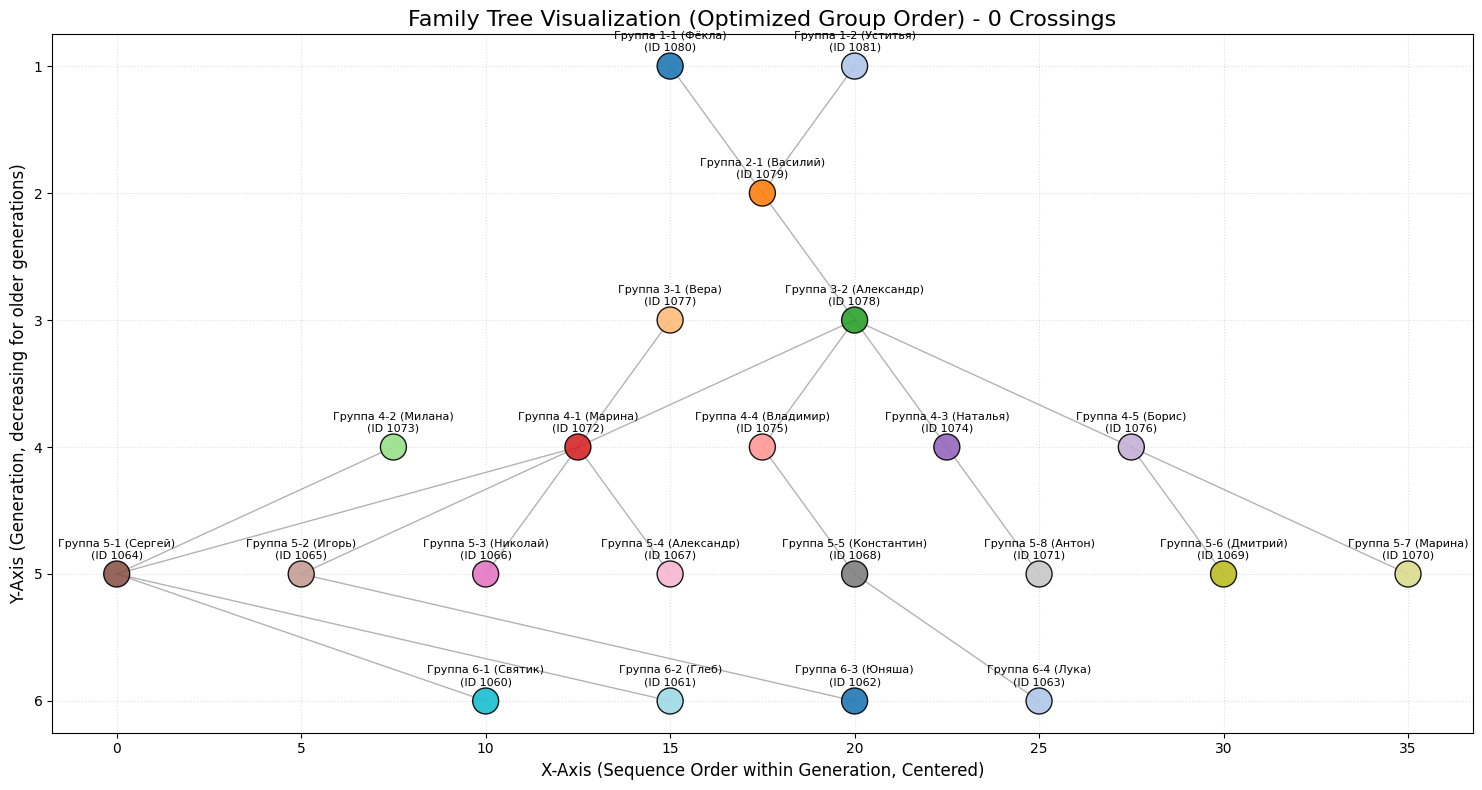



--- 2. Generating Plot: Full Individual Order ---


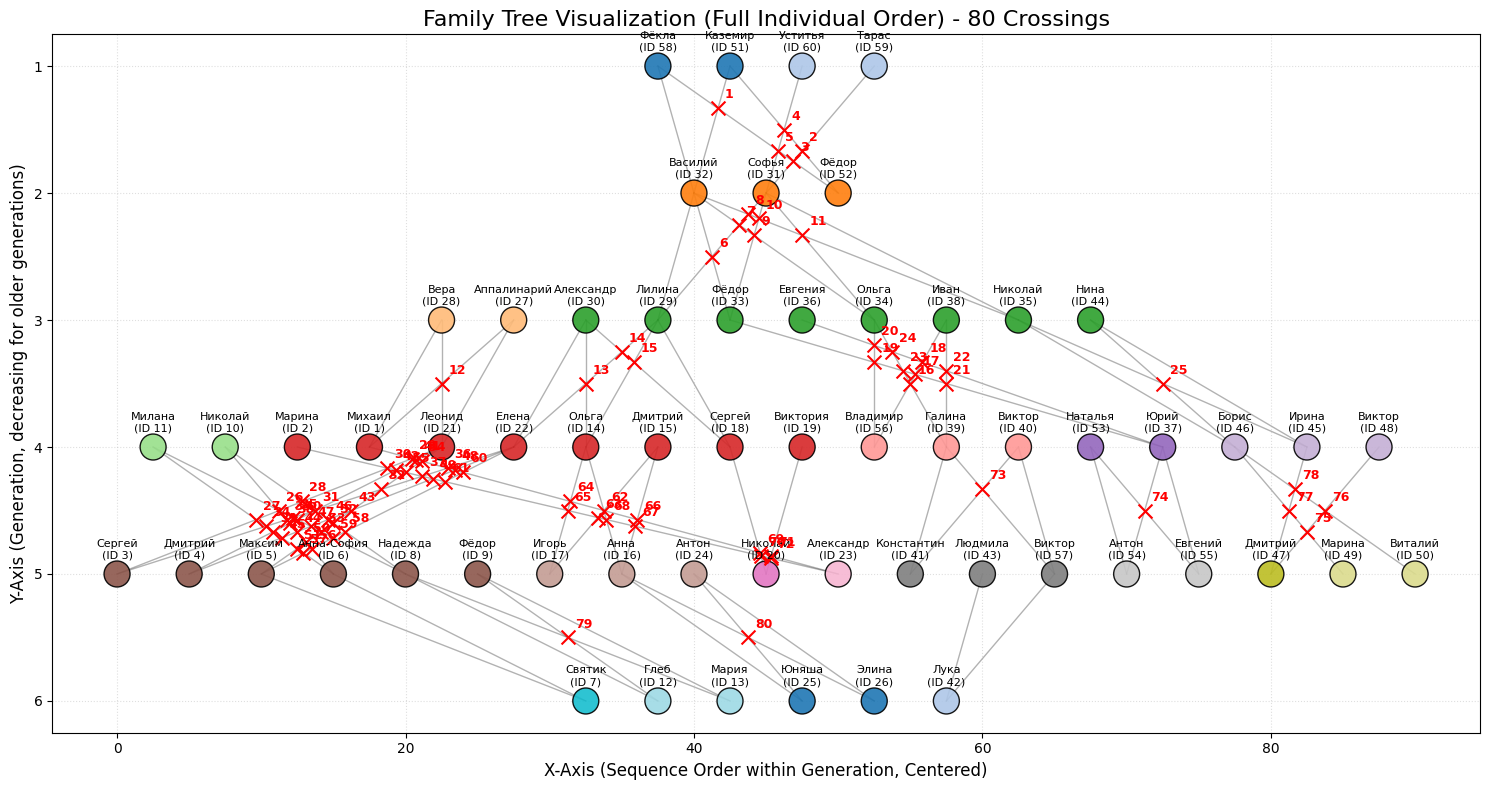

In [4]:
#cell 4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict, OrderedDict
import math
import re # Included though regex is primarily for JS parsing, keeping just in case

# =============================================================
# ASSUMED GLOBAL VARIABLES (Must be defined in a preceding cell)
# =============================================================
# final_coordinates_data: DataFrame with optimized 'x' and 'y' for collapsed groups.
# df_combined: DataFrame of collapsed groups, containing 'OriginalGroupIDs', 'Generation', and parent columns.
# df: Original DataFrame of individuals, used for link lookup.
# PERSON_ID_COLUMN, PARENT_COLUMNS, NAME_RU_COLUMN: Column name constants.
# X_SPACING_UNIT: (Set to 5 in the visualization logic, overriding Code 1's 10)

# =============================================================
# HELPER FUNCTIONS (From Code 2)
# =============================================================

def calculate_intersection_point(P1_coord, C1_coord, P2_coord, C2_coord, y_parent, y_child):
    """Calculates the intersection point of two line segments spanning the same two generations."""
    x_p1, x_c1 = P1_coord[0], C1_coord[0]
    x_p2, x_c2 = P2_coord[0], C2_coord[0]

    # Check if they cross horizontally
    if (x_p1 < x_p2 and x_c1 > x_c2) or (x_p1 > x_p2 and x_c1 < x_c2):
        denominator = (x_p1 - x_p2) - (x_c1 - x_c2)
        if abs(denominator) < 1e-9:
            return None 
        numerator = x_p1 - x_p2
        k = numerator / denominator
        
        if 0 < k < 1:
            x_i = x_p1 + k * (x_c1 - x_p1)
            y_i = y_parent + k * (y_child - y_parent)
            return (x_i, y_i)
            
    return None

def ensure_list_like(val):
    # This utility is necessary for robustly handling parent columns from df_combined/df
    if val is None:
        return []
    if isinstance(val, (list, set, tuple, np.ndarray)):
        return [v for v in val if v is not None and not (isinstance(v, float) and pd.isna(v))]
    else:
        try:
            if pd.isna(val):
                return []
        except Exception:
            pass
        return [val]


# =============================================================
# ORDER DERIVATION (Logic from Code 1, Steps 1 & 2)
# =============================================================

# --- 1. Merge optimized coordinates with group content details ---
df_groups_detail = df_combined[[PERSON_ID_COLUMN, 'Generation', 'OriginalGroupIDs']].copy()
df_optimized_coords = final_coordinates_data[[PERSON_ID_COLUMN, 'x']].copy()

df_merged_sorted = pd.merge(
    df_groups_detail,
    df_optimized_coords,
    on=PERSON_ID_COLUMN,
    how='inner'
)

# Sort by Generation and the optimized 'x' coordinate
df_merged_sorted = df_merged_sorted.sort_values(by=['Generation', 'x'])

# --- 2a. Ordered list of COLLAPSED group IDs ---
collapsed_group_sequences = OrderedDict()

for gen_num, df_gen_sorted in df_merged_sorted.groupby('Generation'):
    # The groups themselves are ordered by the optimized 'x'
    ordered_group_ids = [int(row[PERSON_ID_COLUMN]) for _, row in df_gen_sorted.iterrows()]
    collapsed_group_sequences[int(gen_num)] = ordered_group_ids


# --- 2b. Ordered list of ALL original people IDs (full) ---
final_people_sequences = OrderedDict()

for gen_num, df_gen_sorted in df_merged_sorted.groupby('Generation'):
    ordered_people_pids = []
    for _, group_row in df_gen_sorted.iterrows():
        # Extend the list with the individual PIDs within the group, maintaining group order
        original_pids = group_row["OriginalGroupIDs"]
        # Ensure original_pids is a list of integers (important for consistency)
        ordered_people_pids.extend([int(pid) for pid in ensure_list_like(original_pids)])
    final_people_sequences[int(gen_num)] = ordered_people_pids


print("Order derivation complete. Ready for visualization.")
print("-" * 50)


# =============================================================
# MAIN VISUALIZATION FUNCTION (From Code 2)
# =============================================================

def generate_and_plot_tree(order_dict, title_suffix, is_group_plot, group_order):
    """
    Generates coordinates, finds links, calculates intersections, and plots 
    the family tree based on the provided generation order dictionary.
    
    :param order_dict: Dictionary mapping Generation -> [Ordered IDs]
    :param title_suffix: String to append to the plot title
    :param is_group_plot: True if plotting Group IDs, False if plotting Person IDs
    :param group_order: The dictionary of the group order (used for coloring the full plot)
    """
    
    # Check for necessary global variables
    if ('df' not in globals() or 'df_combined' not in globals() or 
        'PERSON_ID_COLUMN' not in globals() or 'PARENT_COLUMNS' not in globals() or 
        'NAME_RU_COLUMN' not in globals()):
        print("Error: Global DataFrames (df, df_combined) or column constants are missing.")
        return

    # --- 1. Prepare Plotting Data (Coordinates) ---
    X_SPACING_UNIT = 5  # Using the constant from Code 2 for plot aesthetics
    plot_data = []
    global_color_index = 0
    
    # === 1a. Pre-calculate widths and find max_x for centering ===
    max_nodes = max((len(ids) for ids in order_dict.values()), default=0)
    max_width_x = (max_nodes - 1) * X_SPACING_UNIT 

    # Create a quick-lookup map for Group ID -> ColorIndex
    group_color_map = {}
    if group_order:
        for i, (gen, ids) in enumerate(sorted(group_order.items())):
            for group_id in ids:
                group_color_map[group_id] = global_color_index % 20 # Use modulo for 'tab20'
                global_color_index += 1
    
    global_color_index = 0

    for gen, ordered_ids in sorted(order_dict.items()):
        y_coord = -gen * 10
        
        # Calculate offset to center this generation relative to max_width_x
        num_nodes = len(ordered_ids)
        current_width_x = (num_nodes - 1) * X_SPACING_UNIT
        centering_offset = (max_width_x - current_width_x) / 2 if max_nodes > 1 else 0

        x_position_index = 0
        
        # Source DataFrame for name lookups
        node_name_source = df_combined if is_group_plot else df
        
        for node_id in ordered_ids:
            node_id_int = int(node_id)
            # Match the node ID in the source DataFrame
            row_match = node_name_source[node_name_source[PERSON_ID_COLUMN] == node_id_int]
            
            if not row_match.empty:
                row = row_match.iloc[0]
                
                if is_group_plot:
                    # Group Plot: Color each group uniquely
                    color_index = global_color_index % 20
                    name_display = row.get(NAME_RU_COLUMN, f"Group {node_id}")
                    global_color_index += 1
                else:
                    # Full Plot: Color by the group the individual belongs to
                    name_display = row.get(NAME_RU_COLUMN, f"ID {node_id}")
                    
                    # Find the group this individual belongs to for consistent coloring
                    color_index = gen # Default fallback
                    # Note: OriginalGroupIDs should be a list/tuple of IDs
                    group_match = df_combined[df_combined['OriginalGroupIDs'].apply(lambda x: node_id_int in ensure_list_like(x))]
                    
                    if not group_match.empty:
                        group_id = group_match.iloc[0][PERSON_ID_COLUMN]
                        color_index = group_color_map.get(group_id, gen)
                        
                # Calculate the final centered X coordinate
                centered_x = centering_offset + x_position_index * X_SPACING_UNIT
                        
                plot_data.append({
                    'PersonID': node_id_int,
                    'Name-ru': name_display, 
                    'Generation': gen,
                    'x': centered_x,
                    'y': y_coord,
                    'ColorIndex': color_index,
                })
                x_position_index += 1 

    plot_df = pd.DataFrame(plot_data)
    
    if plot_df.empty:
        print(f"No coordinate data to plot for {title_suffix}.")
        return


    # --- 2. Collect Segments (Links) and Coordinate Map ---
    all_segments = []
    intersection_points = []
    coord_map = plot_df.set_index('PersonID')[['x', 'y']].to_dict('index')
    unique_plotted_links = set()

    for _, row in plot_df.iterrows():
        child_id = row['PersonID'] # Plotted ID (Group ID or Person ID)
        
        # Determine the individual PIDs that make up this child node/group
        if is_group_plot:
            group_match = df_combined[df_combined[PERSON_ID_COLUMN] == child_id]
            if group_match.empty: continue
            original_pids = ensure_list_like(group_match.iloc[0]['OriginalGroupIDs'])
        else:
            original_pids = [child_id]
        
        # Iterate over all individuals represented by the child node/group
        for original_child_pid in original_pids:
            original_row_match = df[df[PERSON_ID_COLUMN] == original_child_pid]
            
            if original_row_match.empty: continue
            original_row = original_row_match.iloc[0]
            
            for parent_col in PARENT_COLUMNS:
                parent_pid_raw = original_row.get(parent_col)
                
                if pd.notna(parent_pid_raw):
                    try:
                        parent_pid = int(parent_pid_raw)
                    except ValueError:
                        continue
                    
                    # Determine the parent's PLOTTED ID (Group ID or Person ID)
                    if is_group_plot:
                        parent_group_match = df_combined[df_combined['OriginalGroupIDs'].apply(lambda x: parent_pid in ensure_list_like(x))]
                        if parent_group_match.empty: continue
                        parent_plot_id = parent_group_match.iloc[0][PERSON_ID_COLUMN] # Group ID
                    else:
                        parent_plot_id = parent_pid # Person ID
                        
                    # If both parent and child are plotted nodes
                    if parent_plot_id in coord_map and child_id in coord_map:
                        
                        link_key = tuple(sorted((parent_plot_id, child_id)))
                        if link_key not in unique_plotted_links:
                            unique_plotted_links.add(link_key)
                            
                            p_coord = (coord_map[parent_plot_id]['x'], coord_map[parent_plot_id]['y'])
                            c_coord = (coord_map[child_id]['x'], coord_map[child_id]['y'])
                            
                            if p_coord[1] != c_coord[1]: # Only link across generations
                                all_segments.append({'P_ID': parent_plot_id, 'C_ID': child_id, 'P_COORD': p_coord, 'C_COORD': c_coord})
                            
    # --- 3. Find Intersections ---
    segments_by_gen_pair = defaultdict(list)
    for seg in all_segments:
        segments_by_gen_pair[seg['P_COORD'][1]].append(seg)

    for y_parent, segments in segments_by_gen_pair.items():
        if len(segments) < 2: continue
        y_child = segments[0]['C_COORD'][1] 
        
        for seg_a, seg_b in itertools.combinations(segments, 2):
            intersection = calculate_intersection_point(seg_a['P_COORD'], seg_a['C_COORD'], 
                                                        seg_b['P_COORD'], seg_b['C_COORD'], 
                                                        y_parent, y_child)
            if intersection and intersection not in intersection_points:
                intersection_points.append(intersection)
                    
    # --- 4. Create the Scatter Plot ---
    fig, ax = plt.subplots(figsize=(15, 8))

    # --- 4a. Draw Connections (Lines) ---
    for seg in all_segments:
        ax.plot([seg['C_COORD'][0], seg['P_COORD'][0]], [seg['C_COORD'][1], seg['P_COORD'][1]], 
                'k-', alpha=0.3, linewidth=1, zorder=1) 

    # --- 4b. Draw Intersections ---
    total_crossings = len(intersection_points)
    if intersection_points:
        ix_x = [p[0] for p in intersection_points]
        ix_y = [p[1] for p in intersection_points]
        ax.scatter(ix_x, ix_y, c='red', marker='x', s=100, 
                   label=f'{total_crossings} Crossings', zorder=3)
        
        # Annotate with numbers
        for i, (x_i, y_i) in enumerate(intersection_points):
            ax.annotate(str(i + 1), (x_i, y_i), textcoords="offset points", xytext=(5, 5), 
                        ha='left', va='bottom', fontsize=9, color='red', fontweight='bold', zorder=4)

    # --- 4c. Draw Nodes (Points) ---
    ax.scatter(plot_df['x'], plot_df['y'],
               c=plot_df['ColorIndex'], cmap='tab20', s=350, 
               alpha=0.9, edgecolors='black', linewidths=1.0, zorder=2)

    # --- 5. Add Annotations: Name and PersonID ---
    for _, row in plot_df.iterrows():
        ax.annotate(
            f"{row['Name-ru']}\n(ID {row['PersonID']})", 
            (row['x'], row['y']),
            textcoords="offset points", xytext=(0, 10), ha='center', va='bottom', 
            fontsize=8, color='black'
        )

    # --- 6. Final Touches ---
    plt.title(f"Family Tree Visualization ({title_suffix}) - {total_crossings} Crossings", fontsize=16)
    plt.xlabel("X-Axis (Sequence Order within Generation, Centered)", fontsize=12)
    plt.ylabel("Y-Axis (Generation, decreasing for older generations)", fontsize=12)

    ax.set_aspect('auto', adjustable='box') 
    ax.grid(True, linestyle=':', alpha=0.4)
    if not plot_df.empty:
        ax.set_yticks(sorted(plot_df['y'].unique()))
        ax.set_yticklabels(sorted(plot_df['Generation'].unique(), reverse=True))
    
    plt.tight_layout()
    plt.show()

# =============================================================
# COMBINED EXECUTION
# =============================================================

print("--- 1. Generating Plot: Optimized Group Order ---")
# Plot 1: Collapsed Groups
generate_and_plot_tree(collapsed_group_sequences, "Optimized Group Order", True, collapsed_group_sequences)

print("\n" + "="*80 + "\n")

print("--- 2. Generating Plot: Full Individual Order ---")
# Plot 2: Full Individuals (uses group_sequences for coloring)
generate_and_plot_tree(final_people_sequences, "Full Individual Order", False, collapsed_group_sequences)

### Cell 5 - solo group reorder ###




--- Starting Solo Crossing Group Analysis and Optimization ---
Initial Intersections (Full Plot): 86

- Optimizing Solo Person: 'Святик' (PID: 7, Group ID: 1060)
  No better position found for Святик. Skipping move.

- Optimizing Solo Person: 'Лука' (PID: 42, Group ID: 1063)
  No better position found for Лука. Skipping move.

- Optimizing Solo Person: 'Николай' (PID: 20, Group ID: 1066)
  SUCCESS! Moved node for Николай. Reduction: 4 crossings.
  New Total Intersections: 82

- Optimizing Solo Person: 'Александр' (PID: 23, Group ID: 1067)
  SUCCESS! Moved node for Александр. Reduction: 12 crossings.
  New Total Intersections: 70

- Optimizing Solo Person: 'Дмитрий' (PID: 47, Group ID: 1069)
  SUCCESS! Moved node for Дмитрий. Reduction: 4 crossings.
  New Total Intersections: 66

--- Optimization Complete ---
Total Intersections Reduced by Solo Group Movement: 20
Final Intersections (Full Plot): 66


Generating Plot 1: Optimized Group Order (unchanged)


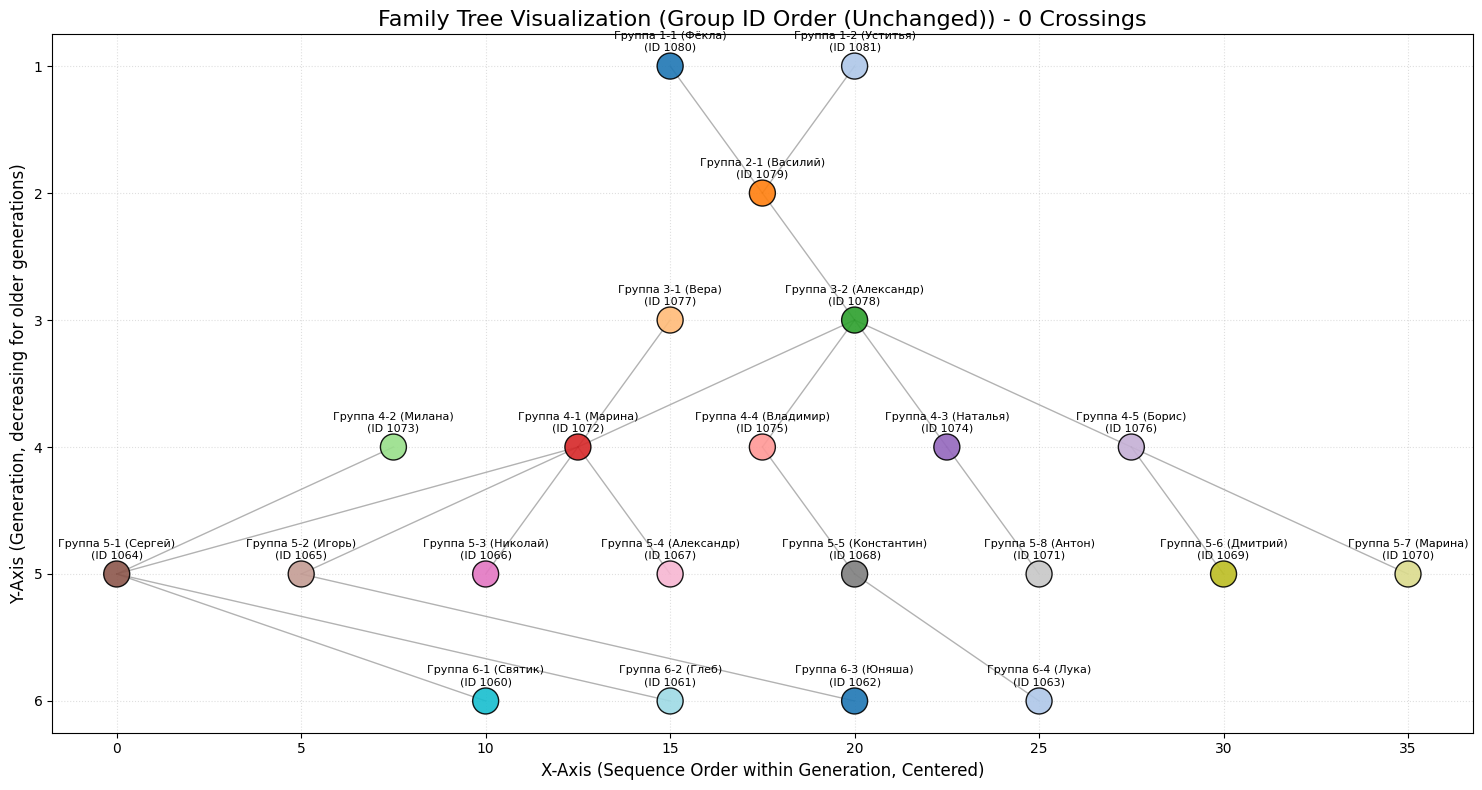



Generating Plot 2: Optimized Full Individual Order (after solo group movement)


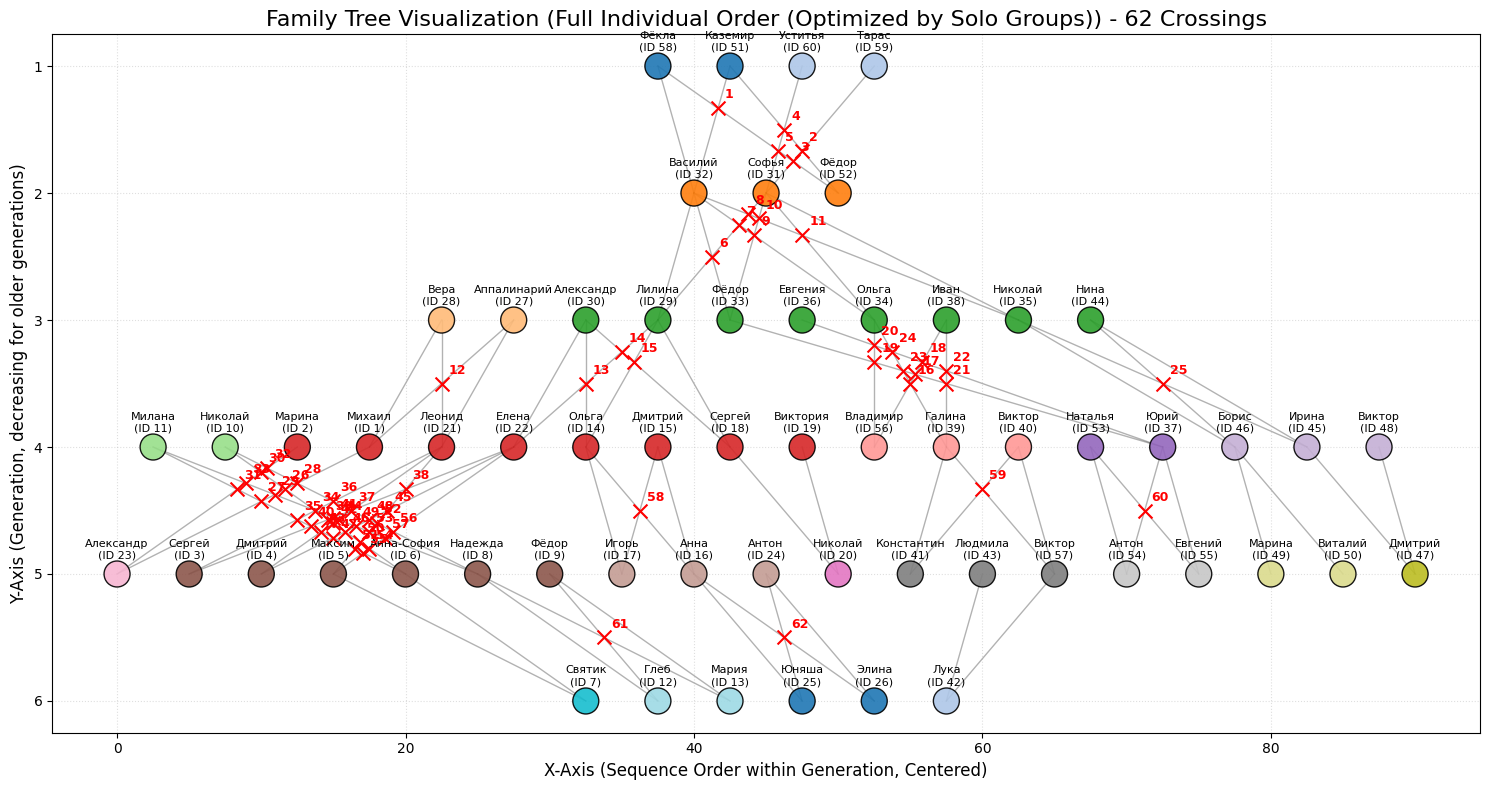

In [5]:
#cell 5

# ====================================================================
# Cell 10 — Analysis and Optimization of Solo Crossing Groups
# (Modified to use in-memory variables from previous execution)
# ====================================================================

# NOTE: The execution of the previous cell must have defined:
# - collapsed_group_sequences (for group_order)
# - final_people_sequences (for full_order)
# - df, df_combined, PERSON_ID_COLUMN, PARENT_COLUMNS, NAME_RU_COLUMN (from initial setup)
# - generate_and_plot_tree (from previous merged code)
# - calculate_intersection_point (from previous merged code)

import pandas as pd
from collections import defaultdict, OrderedDict
import itertools
import math
import matplotlib.pyplot as plt

# ====================================================================
# New Analysis Functions
# ====================================================================

def count_intersections(order_dict, coord_map, df, PERSON_ID_COLUMN, PARENT_COLUMNS):
    """Calculates the total number of intersections for a given full tree order."""
    
    # We rely on the GLOBAL calculate_intersection_point from the previous cell's execution
    if 'calculate_intersection_point' not in globals():
        raise NameError("calculate_intersection_point must be defined globally from previous steps.")

    all_segments = []
    unique_plotted_links = set()
    
    # Iterate through all individuals in the original data to find all links
    for _, row in df.iterrows():
        child_pid = int(row[PERSON_ID_COLUMN])
        for parent_col in PARENT_COLUMNS:
            parent_pid_raw = row.get(parent_col)
            
            # Use ensure_list_like if necessary for robustness, but here we expect single PID links from 'df'
            if pd.notna(parent_pid_raw):
                try: parent_pid = int(parent_pid_raw)
                except: continue
                
                # Check if both parent and child are present in the coordinate map
                if parent_pid in coord_map and child_pid in coord_map:
                    
                    # Ensure each link is counted only once
                    link_key = tuple(sorted((parent_pid, child_pid)))
                    if link_key not in unique_plotted_links:
                        unique_plotted_links.add(link_key)
                        
                        p_coord = (coord_map[parent_pid]['x'], coord_map[parent_pid]['y'])
                        c_coord = (coord_map[child_pid]['x'], coord_map[child_pid]['y'])
                        
                        if p_coord[1] != c_coord[1]: # Only inter-generation links
                            all_segments.append({
                                'P_PID': parent_pid, 
                                'C_PID': child_pid, 
                                'P_COORD': p_coord, 
                                'C_COORD': c_coord
                            })

    segments_by_gen_pair = defaultdict(list)
    for seg in all_segments:
        # Group segments by the Y-coordinate of the parent generation
        segments_by_gen_pair[seg['P_COORD'][1]].append(seg)
    
    total_intersections = 0
    for y_parent, segments in segments_by_gen_pair.items():
        if len(segments) < 2:
            continue
        y_child = segments[0]['C_COORD'][1]
        
        for seg_a, seg_b in itertools.combinations(segments, 2):
            intersection = calculate_intersection_point(
                seg_a['P_COORD'], seg_a['C_COORD'], 
                seg_b['P_COORD'], seg_b['C_COORD'], 
                y_parent, y_child
            )
            if intersection:
                total_intersections += 1
                
    return total_intersections


def generate_coords_and_count_for_solo_opt(order):
    """Helper function to map PIDs to new coordinates and count crossings."""
    X_SPACING_UNIT = 5
    max_nodes = max((len(ids) for ids in order.values()), default=0)
    max_width_x = (max_nodes - 1) * X_SPACING_UNIT
    plot_data = []
    
    for gen, ordered_ids in sorted(order.items()):
        y_coord = -gen * 10
        num_nodes = len(ordered_ids)
        current_width_x = (num_nodes - 1) * X_SPACING_UNIT
        centering_offset = (max_width_x - current_width_x) / 2 if max_nodes > 1 else 0
        
        for i, node_id in enumerate(ordered_ids):
            centered_x = centering_offset + i * X_SPACING_UNIT
            plot_data.append({'PersonID': node_id, 'x': centered_x, 'y': y_coord})
            
    coord_map = {d['PersonID']: {'x': d['x'], 'y': d['y']} for d in plot_data}
    
    # Use global df, PERSON_ID_COLUMN, PARENT_COLUMNS
    return coord_map, count_intersections(order, coord_map, df, PERSON_ID_COLUMN, PARENT_COLUMNS)


def optimize_solo_crossing_groups(full_order_dict, group_order_dict, df, df_combined, PERSON_ID_COLUMN, PARENT_COLUMNS):
    """Locally optimize the full individual order to reduce crossings among solo groups."""
    print("\n--- Starting Solo Crossing Group Analysis and Optimization ---")

    # Identify solo groups (groups containing only one original person ID)
    solo_groups = df_combined[df_combined['OriginalGroupIDs'].apply(lambda x: len(ensure_list_like(x)) == 1)].copy()
    person_to_group_map = {
        ensure_list_like(row['OriginalGroupIDs'])[0]: row[PERSON_ID_COLUMN] 
        for _, row in solo_groups.iterrows()
    }

    solo_pids = list(person_to_group_map.keys())
    current_order = {k: list(v) for k, v in full_order_dict.items()} # Working copy

    coord_map, initial_crossings = generate_coords_and_count_for_solo_opt(current_order)
    print(f"Initial Intersections (Full Plot): {initial_crossings}")
    total_optimized = 0

    # Group solo PIDs by their generation
    solo_pids_by_gen = defaultdict(list)
    for gen, pids in current_order.items():
        for pid in pids:
            if pid in solo_pids:
                solo_pids_by_gen[gen].append(pid)

    # Iterate through generations (older to younger) and then through each solo PID
    for gen in sorted(solo_pids_by_gen.keys(), reverse=True):
        for pid in solo_pids_by_gen[gen]:
            group_id = person_to_group_map.get(pid, 'N/A')
            name_match = df[df[PERSON_ID_COLUMN] == pid]
            name = name_match.iloc[0][NAME_RU_COLUMN] if not name_match.empty else f"ID {pid}"
            print(f"\n- Optimizing Solo Person: '{name}' (PID: {pid}, Group ID: {group_id})")

            # Current state of the generation list
            gen_list = current_order[gen]
            current_pos = gen_list.index(pid)
            current_crossings = generate_coords_and_count_for_solo_opt(current_order)[1]
            
            best_order_for_pid = None
            min_crossings = current_crossings

            # Try moving the person to every possible position within their generation
            for new_pos in range(len(gen_list)):
                if new_pos == current_pos:
                    continue
                
                # Create the new generation list by moving the person
                new_gen_list = gen_list[:]
                new_gen_list.pop(current_pos)
                new_gen_list.insert(new_pos, pid)
                
                # Create the temporary full order
                temp_order = {k: list(v) for k, v in current_order.items()}
                temp_order[gen] = new_gen_list
                
                # Calculate crossings for the temporary order
                _, crossings = generate_coords_and_count_for_solo_opt(temp_order)
                
                if crossings < min_crossings:
                    min_crossings = crossings
                    best_order_for_pid = temp_order

            if best_order_for_pid:
                current_order = best_order_for_pid
                reduction = current_crossings - min_crossings
                print(f"  SUCCESS! Moved node for {name}. Reduction: {reduction} crossings.")
                print(f"  New Total Intersections: {min_crossings}")
                total_optimized += reduction
            else:
                print(f"  No better position found for {name}. Skipping move.")

    final_crossings = generate_coords_and_count_for_solo_opt(current_order)[1]
    print(f"\n--- Optimization Complete ---")
    print(f"Total Intersections Reduced by Solo Group Movement: {total_optimized}")
    print(f"Final Intersections (Full Plot): {final_crossings}")
    
    # Convert back to OrderedDict before returning
    final_ordered_dict = OrderedDict(sorted(current_order.items()))
    return final_ordered_dict


# ====================================================================
# --- Combined Execution (Modified) ---
# ====================================================================

# Direct reference to the in-memory variables from the previous cell's execution
group_order = collapsed_group_sequences
full_order = final_people_sequences

print("\n" + "="*80 + "\n")

# Check if necessary variables exist before proceeding
if 'df' in globals() and 'df_combined' in globals() and 'full_order' in globals() and 'group_order' in globals():
    optimized_full_order = optimize_solo_crossing_groups(
        full_order, group_order, df, df_combined, PERSON_ID_COLUMN, PARENT_COLUMNS
    )
    full_order_to_plot = optimized_full_order
else:
    print("Skipping Optimization: required data (df, df_combined, or order dicts) not found.")
    full_order_to_plot = full_order

print("\n" + "="*80 + "\n")

# Plot 1: Group Order (Unchanged by solo optimization)
if group_order:
    print("Generating Plot 1: Optimized Group Order (unchanged)")
    # We rely on the GLOBAL generate_and_plot_tree from the previous cell's execution
    generate_and_plot_tree(group_order, "Group ID Order (Unchanged)", True, group_order)
else:
    print("Skipping Plot 1: 'group_order' not available.")

# Plot 2: Full Individual Order (Optimized by solo group movement)
if full_order_to_plot:
    print("\n" + "="*80 + "\n")
    print("Generating Plot 2: Optimized Full Individual Order (after solo group movement)")
    generate_and_plot_tree(full_order_to_plot, "Full Individual Order (Optimized by Solo Groups)", False, group_order)
else:
    print("Skipping Plot 2: 'full_order' not available for plotting.")

### Cell 6 - save of the current order ###

In [6]:
# ====================================================================
# New Save Script — Save Optimized Full Order and Original Group Order
# ====================================================================

from collections import OrderedDict
import os # <-- IMPORT THE OS MODULE

# --- File paths configured for the parent folder ---
# Use os.path.join(os.path.pardir, filename) to place files one level up
PARENT_DIR = os.path.pardir # Represents '..'
OUTPUT_FILE_COLLAPSED = os.path.join(PARENT_DIR, "manual_order_collapsed.js")
OUTPUT_FILE_FULL = os.path.join(PARENT_DIR, "manual_order.js")

# --- Helper function to save JS object nicely ---
def save_js_order(filename, var_name, data_dict, comment_template):
    """
    Saves an OrderedDict as a nicely formatted JS object file.

    Args:
        filename (str): output JS file path (now points to parent directory)
        var_name (str): JS variable name
        data_dict (OrderedDict): {generation_number: [ids]}
        comment_template (str): template for comments per generation
    """
    try:
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"const {var_name} = {{\n")
            total_gens = len(data_dict)
            for idx, (gen_num, id_list) in enumerate(data_dict.items(), 1):
                ids_line = ', '.join(f'"{pid}"' for pid in id_list)
                comment = comment_template.format(gen_num=gen_num)
                comma = ',' if idx < total_gens else ''
                f.write(f'  "{gen_num}": [{ids_line}]{comma}{comment}\n')
            f.write("};\n")
        print(f"✅ Successfully saved '{os.path.basename(filename)}' in the parent folder ({PARENT_DIR}).")
    except Exception as e:
        print(f"❌ ERROR saving file '{filename}': {e}")


# --- 1. Save Optimized Full Individual Order ---
if 'full_order_to_plot' in globals() and full_order_to_plot:
    full_order_sorted = OrderedDict(sorted(full_order_to_plot.items()))
    save_js_order(
        OUTPUT_FILE_FULL,
        "manualOrderFull",
        full_order_sorted,
        comment_template=" // Generation {gen_num}: left-to-right individual person order (OPTIMIZED)"
    )
else:
    print("Skipping saving 'manual_order.js': 'full_order_to_plot' not found or empty.")


# --- 2. Save Original Collapsed Group Order ---
if 'group_order' in globals() and group_order:
    group_order_sorted = OrderedDict(sorted(group_order.items()))
    save_js_order(
        OUTPUT_FILE_COLLAPSED,
        "manualOrderCollapsed",
        group_order_sorted,
        comment_template=" // Generation {gen_num}: left-to-right group order (Original)"
    )
else:
    print("Skipping saving 'manual_order_collapsed.js': 'group_order' not found or empty.")



###################################################################################################################################################

✅ Successfully saved 'manual_order.js' in the parent folder (..).
✅ Successfully saved 'manual_order_collapsed.js' in the parent folder (..).


### Cell 7 - open current order ###


--- Raw content of manual_order.js ---

const manualOrderFull = {
  "1": ["58", "51", "60", "59"], // Generation 1: left-to-right individual person order (OPTIMIZED)
  "2": ["32", "31", "52"], // Generation 2: left-to-right individual person order (OPTIMIZED)
  "3": ["28", "27", "30", "29", "33", "36", "34", "38", "35", "44"], // Generation 3: left-to-right individual person order (OPTIMIZED)
  "4": ["11", "10", "2", "1", "21", "22", "14", "15", "18", "19", "56", "39", "40", "53", "37", "46", "45", "48"], // Generation 4: left-to-right individual person order (OPTIMIZED)
  "5": ["23", "3", "4", "5", "6", "8", "9", "17", "16", "24", "20", "41", "43", "57", "54", "55", "49", "50", "47"], // Generation 5: left-to-right individual person order (OPTIMIZED)
  "6": ["7", "12", "13", "25", "26", "42"] // Generation 6: left-to-right individual person order (OPTIMIZED)
};


--- End of raw content ---


--- Parsed OrderedDict from manual_order.js ---
1: ['58', '51', '60', '59']
2: ['32', '31', '

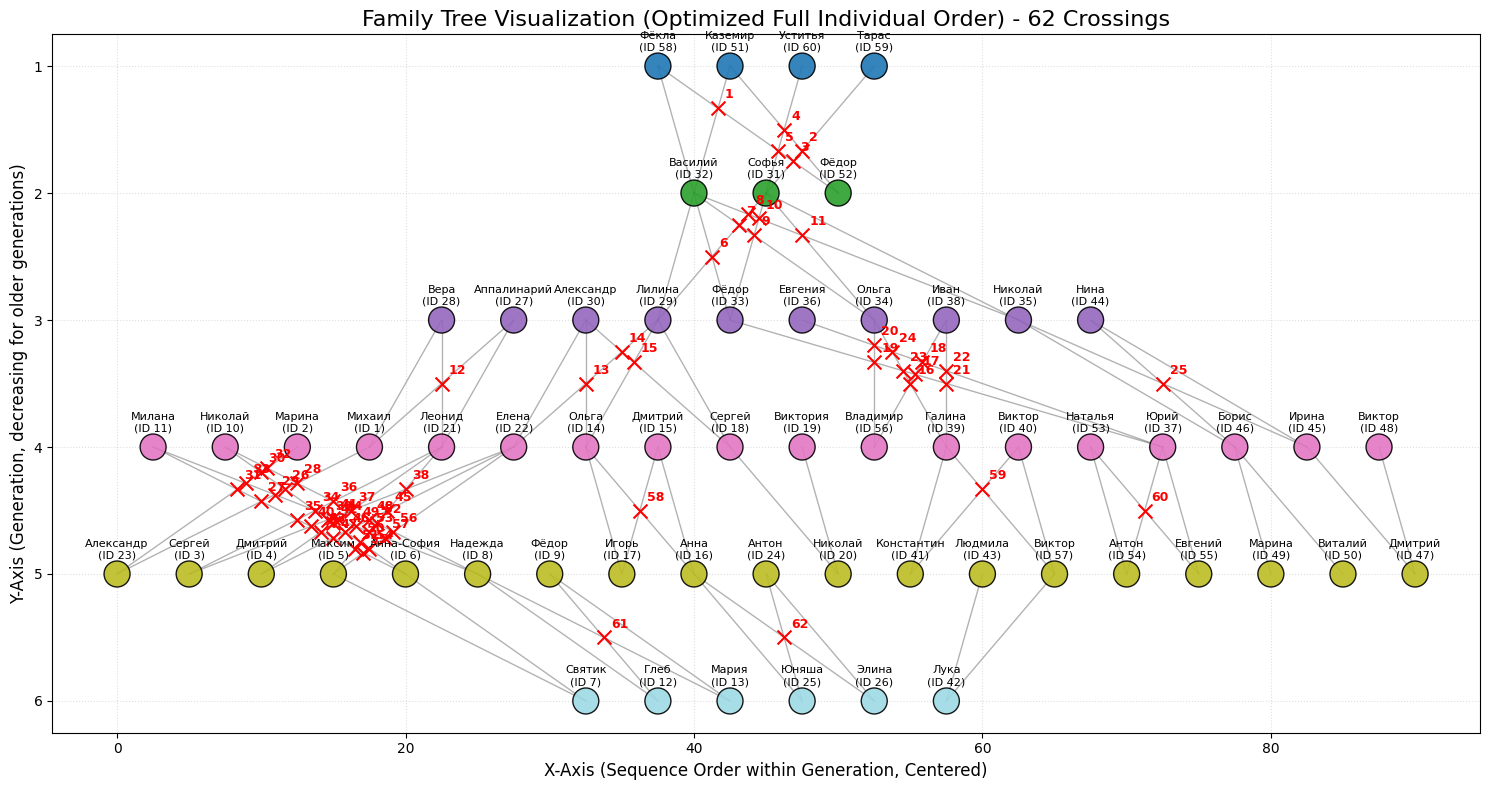

In [7]:
# ====================================================================
# Script to Open Saved Full Individual Order and Visualize
# ====================================================================

import os
from collections import OrderedDict
import re

# --- Parent directory reference ---
PARENT_DIR = os.path.pardir  # '..'

# --- File path for the full individual order ---
FILE_FULL_ORDER = os.path.join(PARENT_DIR, "manual_order.js")

# --- Helper function to parse JS order files ---
def load_js_order(filepath: str):
    """
    Reads a JS object file saved like: const VAR_NAME = { ... };
    Strips comments and converts to OrderedDict[int, list].
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()

        print(f"\n--- Raw content of {os.path.basename(filepath)} ---\n")
        print(content)
        print("\n--- End of raw content ---\n")

        # Remove JS const declaration and semicolon
        content = re.sub(r"const\s+\w+\s*=\s*", "", content).strip().rstrip(";")
        # Remove all inline comments
        content = re.sub(r"//.*", "", content)
        # Remove newlines and extra spaces
        content = content.replace("\n", "").replace("\r", "").strip()

        # Extract "generation": [IDs] blocks
        pattern = r'"?(\d+)"?\s*:\s*\[(.*?)\]'
        matches = re.findall(pattern, content)
        result = OrderedDict()
        for gen_str, ids_str in matches:
            gen_num = int(gen_str)
            ids_list = [x.strip().strip('"') for x in ids_str.split(",") if x.strip()]
            result[gen_num] = ids_list

        print(f"\n--- Parsed OrderedDict from {os.path.basename(filepath)} ---")
        for k, v in result.items():
            print(f"{k}: {v}")
        print("--- End of Parsed OrderedDict ---\n")

        return result

    except FileNotFoundError:
        print(f"❌ File not found: {filepath}")
    except Exception as e:
        print(f"❌ Error reading {filepath}: {e}")
    return None

# --- Load full individual order ---
full_order_loaded = load_js_order(FILE_FULL_ORDER)

# --- Visualize only the full individual order ---
if 'generate_and_plot_tree' not in globals():
    raise NameError("generate_and_plot_tree must be defined in the environment to visualize orders.")

if full_order_loaded:
    print("Visualizing Optimized Full Individual Order")
    # Pass collapsed_order_loaded as None since we don't plot groups
    generate_and_plot_tree(full_order_loaded, "Optimized Full Individual Order", False, None)


### Cell 8 - manual reorder inside the groups ###


Generation 2 current order: 32, 31, 52
Enter new order (comma-separated integers), or leave empty to keep unchanged:


✅ Updated Generation 2: 31, 32, 52

Plotting manually edited full order...


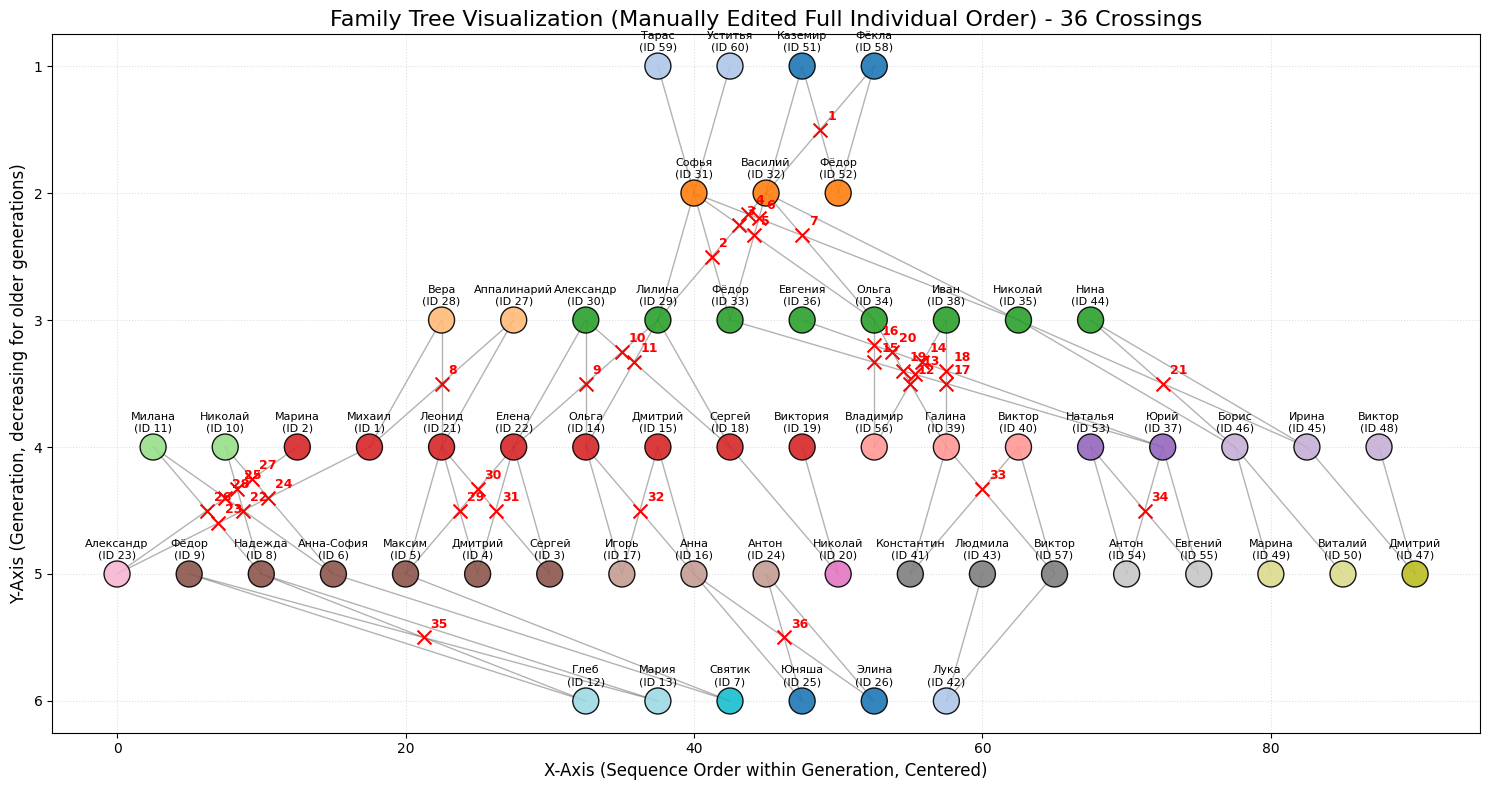

In [12]:
# ====================================================================
# Full Cell: Manual Edit and Safe Re-Plot (Numeric IDs Only)
# ====================================================================

from collections import OrderedDict

collapsed_order_loaded = group_order

def show_and_edit_generations_numeric(order_dict, selected_gens):
    """
    Prints selected generations, allows manual edits, ensures numeric IDs,
    and keeps all generations (including last) for plotting.
    
    Args:
        order_dict (OrderedDict): {generation_number: [ids]}
        selected_gens (list[int]): generations to inspect/edit
    
    Returns:
        OrderedDict: updated order_dict (numeric IDs only)
    """
    if not order_dict:
        print("❌ Order dictionary is empty.")
        return order_dict

    updated_order = OrderedDict(order_dict)  # copy

    for gen_num in selected_gens:
        if gen_num not in order_dict:
            print(f"⚠️ Generation {gen_num} not found.")
            continue

        # Clean IDs: remove whitespace, keep only integers
        current_ids = []
        for pid in updated_order[gen_num]:
            try:
                pid_clean = str(int(str(pid).strip()))
                current_ids.append(pid_clean)
            except:
                pass
        print(f"\nGeneration {gen_num} current order: {', '.join(current_ids)}")

        # Prompt for manual edit
        print("Enter new order (comma-separated integers), or leave empty to keep unchanged:")
        user_input = input(">>> ").strip()
        if user_input:
            new_ids = []
            for x in user_input.split(","):
                x = x.strip()
                try:
                    new_ids.append(str(int(x)))  # only valid integers
                except:
                    print(f"⚠️ Skipping invalid ID: {x}")
            updated_order[gen_num] = new_ids
            print(f"✅ Updated Generation {gen_num}: {', '.join(new_ids)}")
        else:
            updated_order[gen_num] = current_ids  # keep cleaned list
            print(f"↩️ Generation {gen_num} left unchanged.")

    # Sanitize all generations but keep empty lists
    sanitized_order = OrderedDict()
    for gen, ids in updated_order.items():
        valid_ids = []
        for pid in ids:
            try:
                valid_ids.append(str(int(str(pid).strip())))
            except:
                pass
        sanitized_order[gen] = valid_ids  # keep empty list if nothing valid

    return sanitized_order


# ====================================================================
# Example usage
# ====================================================================

# Specify which generations you want to manually edit
gens_to_edit = [2]  # change as needed

if full_order_loaded:
    full_order_loaded = show_and_edit_generations_numeric(full_order_loaded, gens_to_edit)

# --- Re-plot safely ---
if 'generate_and_plot_tree' in globals() and full_order_loaded:
    print("\nPlotting manually edited full order...")
    generate_and_plot_tree(
        full_order_loaded,
        "Manually Edited Full Individual Order",
        False,
        collapsed_order_loaded
    )


### Cell 9 - save of manual reorder ###

In [13]:
# ====================================================================
# Save Manually Edited Orders with "_regrouped" in filenames
# ====================================================================

import os
from collections import OrderedDict

# Parent directory (same as before)
PARENT_DIR = os.path.pardir

# Output filenames with "_regrouped" suffix
OUTPUT_FILE_FULL = os.path.join(PARENT_DIR, "manual_order_regrouped.js")
OUTPUT_FILE_COLLAPSED = os.path.join(PARENT_DIR, "manual_order_collapsed_regrouped.js")

def save_js_order(filename, var_name, data_dict, comment_template):
    """
    Saves an OrderedDict as a nicely formatted JS object file.

    Args:
        filename (str): output JS file path
        var_name (str): JS variable name
        data_dict (OrderedDict): {generation_number: [ids]}
        comment_template (str): template for comments per generation
    """
    try:
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"const {var_name} = {{\n")
            total_gens = len(data_dict)
            for idx, (gen_num, id_list) in enumerate(data_dict.items(), 1):
                ids_line = ', '.join(f'"{pid}"' for pid in id_list)
                comment = comment_template.format(gen_num=gen_num)
                comma = ',' if idx < total_gens else ''
                f.write(f'  "{gen_num}": [{ids_line}]{comma}{comment}\n')
            f.write("};\n")
        print(f"✅ Successfully saved '{os.path.basename(filename)}' in {PARENT_DIR}")
    except Exception as e:
        print(f"❌ ERROR saving file '{filename}': {e}")

# --- Save manually edited full order ---
if full_order_loaded:
    full_order_sorted = OrderedDict(sorted(full_order_loaded.items()))
    save_js_order(
        OUTPUT_FILE_FULL,
        "manualOrderFull",
        full_order_sorted,
        comment_template=" // Generation {gen_num}: left-to-right individual person order (REGROUPED)"
    )
else:
    print("Skipping saving 'manual_order_regrouped.js': full_order_loaded is empty or not defined.")

# --- Save original collapsed group order (regrouped version) ---
if collapsed_order_loaded:
    collapsed_order_sorted = OrderedDict(sorted(collapsed_order_loaded.items()))
    save_js_order(
        OUTPUT_FILE_COLLAPSED,
        "manualOrderCollapsed",
        collapsed_order_sorted,
        comment_template=" // Generation {gen_num}: left-to-right group order (REGROUPED)"
    )
else:
    print("Skipping saving 'manual_order_collapsed_regrouped.js': collapsed_order_loaded is empty or not defined.")


✅ Successfully saved 'manual_order_regrouped.js' in ..
✅ Successfully saved 'manual_order_collapsed_regrouped.js' in ..
